# Loan Eligibility with Ensemble Boosting

## Table of Contents

> [1. Abstract](#Abstract--1)

> [2. Import of the Dataset](#DatasetImport--2)
>> - [2.1. Dataset Description](#DatasetDescription--2-1)
>> - [2.2. Missing Values](#NaN--2-2)
>> - [2.3. Numerical and Ordinal Data](#NumericalAndOrdinalData--2-3)
>> - [2.4. General Categorical and Binary Categorical Data](#CategoricalData--2-4)
 
> [3. Data Preprocessing](#DataPreprocessing--3)

> [4. Training the Models](#TrainingTheModels--4)
>> - [4.1. eXtreme Gradient Boosting](#XGBoosting--4-1)
>> - [4.2. Adaptive Boosting](#AdaBoost--4-2)
>> - [4.3. Gradient Boosting](#GradientBoosting--4-3)

> [5. Comparisons](#Comparisons--5)

> [6. Conclusions and Possible Expansions](#ConclusionsAndPossibleExpansions--6)

> [7. Appendix](#Appendix--7)
>> - [7.A. Python stay-awake module](#Appendix--7-A)
>> - [7.B. Python  image converter base64 (PDF exporting)](#Appendix--7-B)

## 1. Abstract <a name="Abstract--1"></a>

Banks and all sort of credit institutes which provide *loans*, face great challenges when a new potential customer asks for a loan.\
These challenges translate into *risks*, which if not properly balanced, may end up with catastrophic consequences for all clients in the financial-chain, and may have a big impact in the outside world too.\
Technology can mitigate these risks.

By gathering a huge amout of *data*, and by applying some analytics we can see the *hidden shape* of the risks that credit institutes take.\
Then, thanks to some state-of-the-art algorithms we can predict the potential risk that a new client may represent for a bank.\
At the end of the day, the aim is to provide a robust model to support difficult *decision-making* scenarios.

The purpose of the notebook is to show and manipulate a huge dataset collected from [Kaggle](https://www.kaggle.com/datasets/yasserh/loan-default-dataset), then after some *feature engineering* we apply and compare three State-of-the-Art *ensemble learning* algorithms for tabular data:
- AdaBoost
- GradientBoost
- XGBoost

Based on statistics we decide which the best one is.\
Further conclusions and possible expansions are presented.

###### [pointer to the dataset on Kaggle](https://www.kaggle.com/datasets/yasserh/loan-default-dataset)

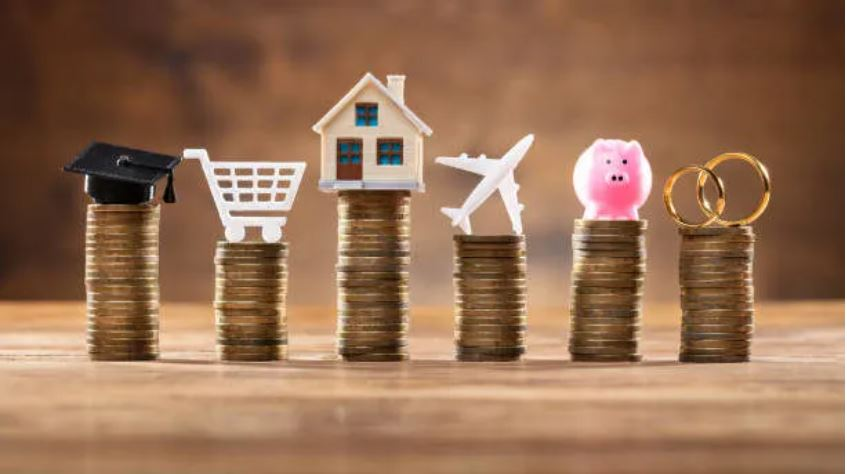

<span style="font-size:80%"> See [Appendix 7.B.](#Appendix--7-B) to understand how this image has been generated </span>

## 2. Dataset Import <a name="DatasetImport--2"></a>

In [1]:
#import of all libraries and packages
import kagglehub #for automatically downloading the dataset from Kaggle IF it has changed
import pandas as pd #data manipulation
import numpy as np #numerical manipulation
import matplotlib.pyplot as plt #data visualization
import matplotlib.patches as mpatches #for distinguishing the dots in the scatter matrix plots
import sklearn #ML
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder #handling categorical data
import sys #get the real size of the DataFrames

In [2]:
#Code to fetch the data
try:
    #Download latest version
    path = kagglehub.dataset_download("yasserh/loan-default-dataset")

    #to check where the dataset has been located
    #print("Path to dataset files:", path)

    loan_data = pd.read_csv(path + '\Loan_Default.csv')

#if something goes wrong (e.g.: connection, wrong path, ...), use the copy of the dataset in the directory
except:
    loan_data = pd.read_csv('Loan_Default.csv')

### 2.1. Dataset Description <a name="DatasetDescription--2-1"></a>

In [3]:
pd.set_option('display.max_columns', 
              None) #display all columns
loan_data.head()

ID  year loan_limit             Gender approv_in_adv loan_type  \
0  24890  2019         cf  Sex Not Available         nopre     type1   
1  24891  2019         cf               Male         nopre     type2   
2  24892  2019         cf               Male           pre     type1   
3  24893  2019         cf               Male         nopre     type1   
4  24894  2019         cf              Joint           pre     type1   

  loan_purpose Credit_Worthiness open_credit business_or_commercial  \
0           p1                l1        nopc                  nob/c   
1           p1                l1        nopc                    b/c   
2           p1                l1        nopc                  nob/c   
3           p4                l1        nopc                  nob/c   
4           p1                l1        nopc                  nob/c   

   loan_amount  rate_of_interest  Interest_rate_spread  Upfront_charges  \
0       116500               NaN                   NaN              NaN   
1       206500               NaN                   NaN              NaN   
2       406500              4.56                0.2000            595.0   
3       456500              4.25                0.6810              NaN   
4       696500              4.00                0.3042              0.0   

    term Neg_ammortization interest_only lump_sum_payment  property_value  \
0  360.0           not_neg       not_int         not_lpsm        118000.0   
1  360.0           not_neg       not_int             lpsm             NaN   
2  360.0           neg_amm       not_int         not_lpsm        508000.0   
3  360.0           not_neg       not_int         not_lpsm        658000.0   
4  360.0           not_neg       not_int         not_lpsm        758000.0   

  construction_type occupancy_type Secured_by total_units   income  \
0                sb             pr       home          1U   1740.0   
1                sb             pr       home          1U   4980.0   
2                sb             pr       home          1U   9480.0   
3                sb             pr       home          1U  11880.0   
4                sb             pr       home          1U  10440.0   

  credit_type  Credit_Score co-applicant_credit_type    age  \
0         EXP           758                      CIB  25-34   
1        EQUI           552                      EXP  55-64   
2         EXP           834                      CIB  35-44   
3         EXP           587                      CIB  45-54   
4        CRIF           602                      EXP  25-34   

  submission_of_application        LTV Region Security_Type  Status  dtir1  
0                   to_inst  98.728814  south        direct       1   45.0  
1                   to_inst        NaN  North        direct       1    NaN  
2                   to_inst  80.019685  south        direct       0   46.0  
3                  not_inst  69.376900  North        direct       0   42.0  
4                  not_inst  91.886544  North        direct       0   39.0

This description may be very helpful through all the notebook's reading, so keep it in sight.

- **ID:** client loan application id  
- **year:** year of loan application  
- **loan limit:** indicates whether the loan is conforming (cf) or non-conforming (ncf)  
- **Gender:** gender of the applicant (male, female, joint, sex not available)  
- **approv_in_adv:** indicates whether the loan was approved in advance (pre, nopre)  
- **loan_type:** type of loan (type1, type2, type3)  :
    * *Type 1 (Conventional Loans):* Characterized by higher loan amounts, lower LTV ratios, and stronger credit scores, making them a preferred option for well-qualified, lower-risk borrowers.
    * *Type 2 (Government-Backed Loans):* Typically involve lower loan amounts, higher LTV ratios, and moderate credit scores, indicating they are used by borrowers with smaller down payments who benefit from government-backed programs.
    * *Type 3 (Non-Conventional Loans):* Feature moderate loan amounts, the highest LTV ratios, and lower credit scores, often associated with higher-risk products such as jumbo loans or adjustable-rate mortgages.
- **loan_purpose:** purpose of the loan (p1, p2, p3, p4):
    * *p1 (Home Purchase):* Represents loans taken out for primary residences, often displaying moderate credit scores and higher LTV ratios.
    * *p2 (Home Improvement):* Smaller loan amounts used for property renovations, with lower LTV ratios suggesting homeowners are leveraging built-up equity.
    * *p3 (Refinancing):* Applies to homeowners replacing an existing mortgage, characterized by moderate loan amounts and lower LTV ratios, indicating financial stability.
    * *p4 (Investment Property):* Involves larger loan amounts and higher risk profiles, primarily financed through conventional loans due to restrictions on Government-backed funding for investment properties.
- **Credit_Worthiness:** credit worthiness (l1, l2)  
- **open_credit:** indicates whether the applicant has any open credit accounts (opc, nopc)  
- **business_or_commercial:** indicates whether the loan is for business/commercial purposes (ob/c - business/commercial, nob/c - personal)  
- **loan_amount:** amount of money being borrowed  
- **rate_of_interest:** interest rate charged on the loan  
- **Interest_rate_spread:** difference between the interest rate on the loan and a benchmark interest rate  
- **Upfront_charges:** initial charges associated with securing the loan  
- **term:** duration of the loan in months  
- **Neg_ammortization:** indicates whether the loan allows for negative amortization (neg_amm, not_neg)  
- **interest_only:** indicates whether the loan has an interest-only payment option (int_only, not_int)  
- **lump_sum_payment:** indicates if a lump sum payment is required at the end of the loan term (lpsm, not_lpsm)  
- **property_value:** value of the property being financed  
- **construction_type:** type of construction (sb - site built, mh - manufactured home)  
- **occupancy_type:** occupancy type (pr - primary residence, sr - secondary residence, ir - investment property)  
- **Secured_by:** specifies the type of collateral securing the loan (home, land)  
- **total_units:** number of units in the property being financed (1U, 2U, 3U, 4U)  
- **income <a name="cite_ref-1"></a>[<sup>*</sup>](#cite_note-1) :** applicant's annual income  
- **credit_type:** applicant's type of credit (CIB - credit information bureau, CRIF - CIRF credit information bureau, EXP - experian, EQUI - equifax)  
- **Credit_Score:** applicant's credit score  
- **co-applicant_credit_type:** co-applicant's type of credit (CIB - credit information bureau, EXP - experian)  
- **age:** the age of the applicant  
- **submission_of_application:** indicates how the application was submitted (to_inst - to institution, not_inst - not to institution)  
- **LTV:** loan-to-value ratio, calculated as the loan amount divided by the property value  
- **Region:** geographic region where the property is located (North, South, Central, North-East)  
- **Security_Type:** type of security or collateral backing the loan (direct, indirect)  
- **Status:** indicates whether the loan has been defaulted (1) or not (0)  
- **dtir1:** debt-to-income ratio  

<a name="cite_note-1"></a>[*](#cite_ref-1) The annual income is in thousands of dollars.

In [4]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

**Notice:** above the **`info()`** command, gives us a memory usage size that is actually a bit misleading, [GitHub issue DataFrame.memory_usage](https://github.com/pandas-dev/pandas/issues/11595).\
That is the reason why we decided to use: **`sys.getsizeof()`**, since this data will be quite interesting especially for the next sections.

In [5]:
sys.getsizeof(loan_data) #size in bytes

207281850

In [6]:
loan_data.describe()

ID      year   loan_amount  rate_of_interest  \
count  148670.000000  148670.0  1.486700e+05     112231.000000   
mean    99224.500000    2019.0  3.311177e+05          4.045476   
std     42917.476598       0.0  1.839093e+05          0.561391   
min     24890.000000    2019.0  1.650000e+04          0.000000   
25%     62057.250000    2019.0  1.965000e+05          3.625000   
50%     99224.500000    2019.0  2.965000e+05          3.990000   
75%    136391.750000    2019.0  4.365000e+05          4.375000   
max    173559.000000    2019.0  3.576500e+06          8.000000   

       Interest_rate_spread  Upfront_charges           term  property_value  \
count         112031.000000    109028.000000  148629.000000    1.335720e+05   
mean               0.441656      3224.996127     335.136582    4.978935e+05   
std                0.513043      3251.121510      58.409084    3.599353e+05   
min               -3.638000         0.000000      96.000000    8.000000e+03   
25%                0.076000       581.490000     360.000000    2.680000e+05   
50%                0.390400      2596.450000     360.000000    4.180000e+05   
75%                0.775400      4812.500000     360.000000    6.280000e+05   
max                3.357000     60000.000000     360.000000    1.650800e+07   

              income   Credit_Score            LTV         Status  \
count  139520.000000  148670.000000  133572.000000  148670.000000   
mean     6957.338876     699.789103      72.746457       0.246445   
std      6496.586382     115.875857      39.967603       0.430942   
min         0.000000     500.000000       0.967478       0.000000   
25%      3720.000000     599.000000      60.474860       0.000000   
50%      5760.000000     699.000000      75.135870       0.000000   
75%      8520.000000     800.000000      86.184211       0.000000   
max    578580.000000     900.000000    7831.250000       1.000000   

               dtir1  
count  124549.000000  
mean       37.732932  
std        10.545435  
min         5.000000  
25%        31.000000  
50%        39.000000  
75%        45.000000  
max        61.000000

Since the columns: **`ID`** and **`year`** are not meaningful for any purposes, we can drop them from the very beginning and still be compliant to the preprocessing best practices.

In [7]:
#since they are not meaningful columns at all, we can drop them for the whole dataset
loan_data = loan_data.drop('ID', axis=1)
loan_data = loan_data.drop('year', axis=1)

In [8]:
#to get insights on the categorical data
categorical_values_counts = list()
for cat in loan_data.select_dtypes(include=['object']).columns: #extract the list of all categorical features
    categorical_values_counts.append(loan_data[f"{cat}"].value_counts())
    categorical_values_counts.append('-'*45) #for spacing them
categorical_values_counts

[cf     135348
 ncf      9978
 Name: loan_limit, dtype: int64,
 '---------------------------------------------',
 Male                 42346
 Joint                41399
 Sex Not Available    37659
 Female               27266
 Name: Gender, dtype: int64,
 '---------------------------------------------',
 nopre    124621
 pre       23141
 Name: approv_in_adv, dtype: int64,
 '---------------------------------------------',
 type1    113173
 type2     20762
 type3     14735
 Name: loan_type, dtype: int64,
 '---------------------------------------------',
 p3    55934
 p4    54799
 p1    34529
 p2     3274
 Name: loan_purpose, dtype: int64,
 '---------------------------------------------',
 l1    142344
 l2      6326
 Name: Credit_Worthiness, dtype: int64,
 '---------------------------------------------',
 nopc    148114
 opc        556
 Name: open_credit, dtype: int64,
 '---------------------------------------------',
 nob/c    127908
 b/c       20762
 Name: business_or_commercial, dtype: 

### 2.2. Missing Values <a name="NaN--2-2"></a>

We can see that the biggest issues in terms of missing values come from: **`Upfront_charges`**, **`Interest_rate_spread`**, **`rate_of_interest`**.
we could have some criticalities also on other features but still negligible, even though we have to keep in mind that the **`NaN`** are spread out as:

#### Numerical 
- 39642 Upfront_charges
- 36639 Interest_rate_spread
- 36439 rate_of_interest
- 24121 dtir1
- 15098 LTV
- 15098 property_value
- 9150 income
- 41 term

#### Categorical
- 3344 loan_limit
- 908 approv_in_adv
- 200 age
- 200 submission_of_application
- 136 loan_purpose
- 121 Neg_ammortization

In the next code blocks we will see how to approach this problem.

### 2.3. Numerical and Ordinal Data <a name="NumericalAndOrdinalData--2-3"></a>

In [9]:
#converting 'total_units' and 'age' categorical data into ordinal
ordinal_encoder = OrdinalEncoder()

#just for the total_units and age features, since it makes sense a concept of ordinal data we transform them this way
total_units_cat = loan_data[['total_units']] #take the column we want to encode
total_units_encoded = ordinal_encoder.fit_transform(total_units_cat) + 1 #we shift the numbers, since we represent the units
loan_data['total_units'] = total_units_encoded #replace the column in the dataset

age_mapping = {
    '<25':1,
    '25-34':2,
    '35-44':3,
    '45-54':4,
    '55-64':5,
    '65-74':6,
    '>74':7
}
loan_data['age'] = loan_data['age'].map(age_mapping) #replace the column in the dataset

In [10]:
#list containing all the numerical + ordinal features plus the target
numerical_ordinal_columns = [col for col in loan_data.columns if col not in loan_data.select_dtypes(include=['category', 'object']).columns]
#list with only the numerical + ordinal features
numerical_ordinal_features = numerical_ordinal_columns.copy()
numerical_ordinal_features.remove('Status')

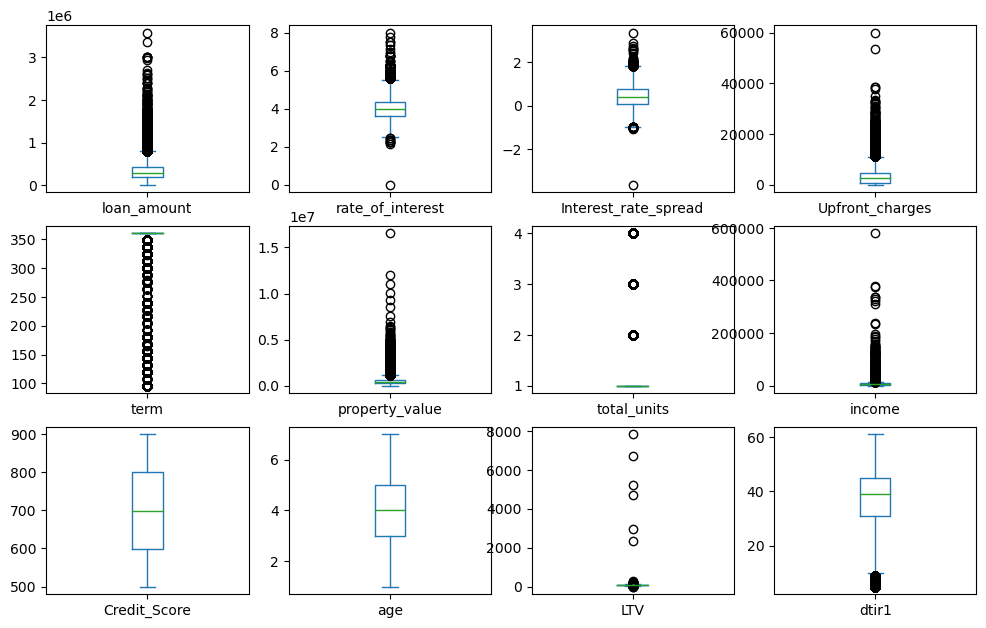

In [11]:
#boxplots
loan_data[numerical_ordinal_features].plot(kind='box', 
                               subplots=True, #distinct box plots for each feature
                               layout= (int(len(numerical_ordinal_features) ** 0.5) + 1, int(len(numerical_ordinal_features) ** 0.5) + 1), #make the plots readable
                               figsize=((int(len(numerical_ordinal_features) ** 0.5) + 1)*3, (int(len(numerical_ordinal_features) ** 0.5) + 1)*2.5),
                               sharex=False, #each subplot uses a different x scale
                               sharey=False #each subplot uses a different y scale
                              )
plt.show()

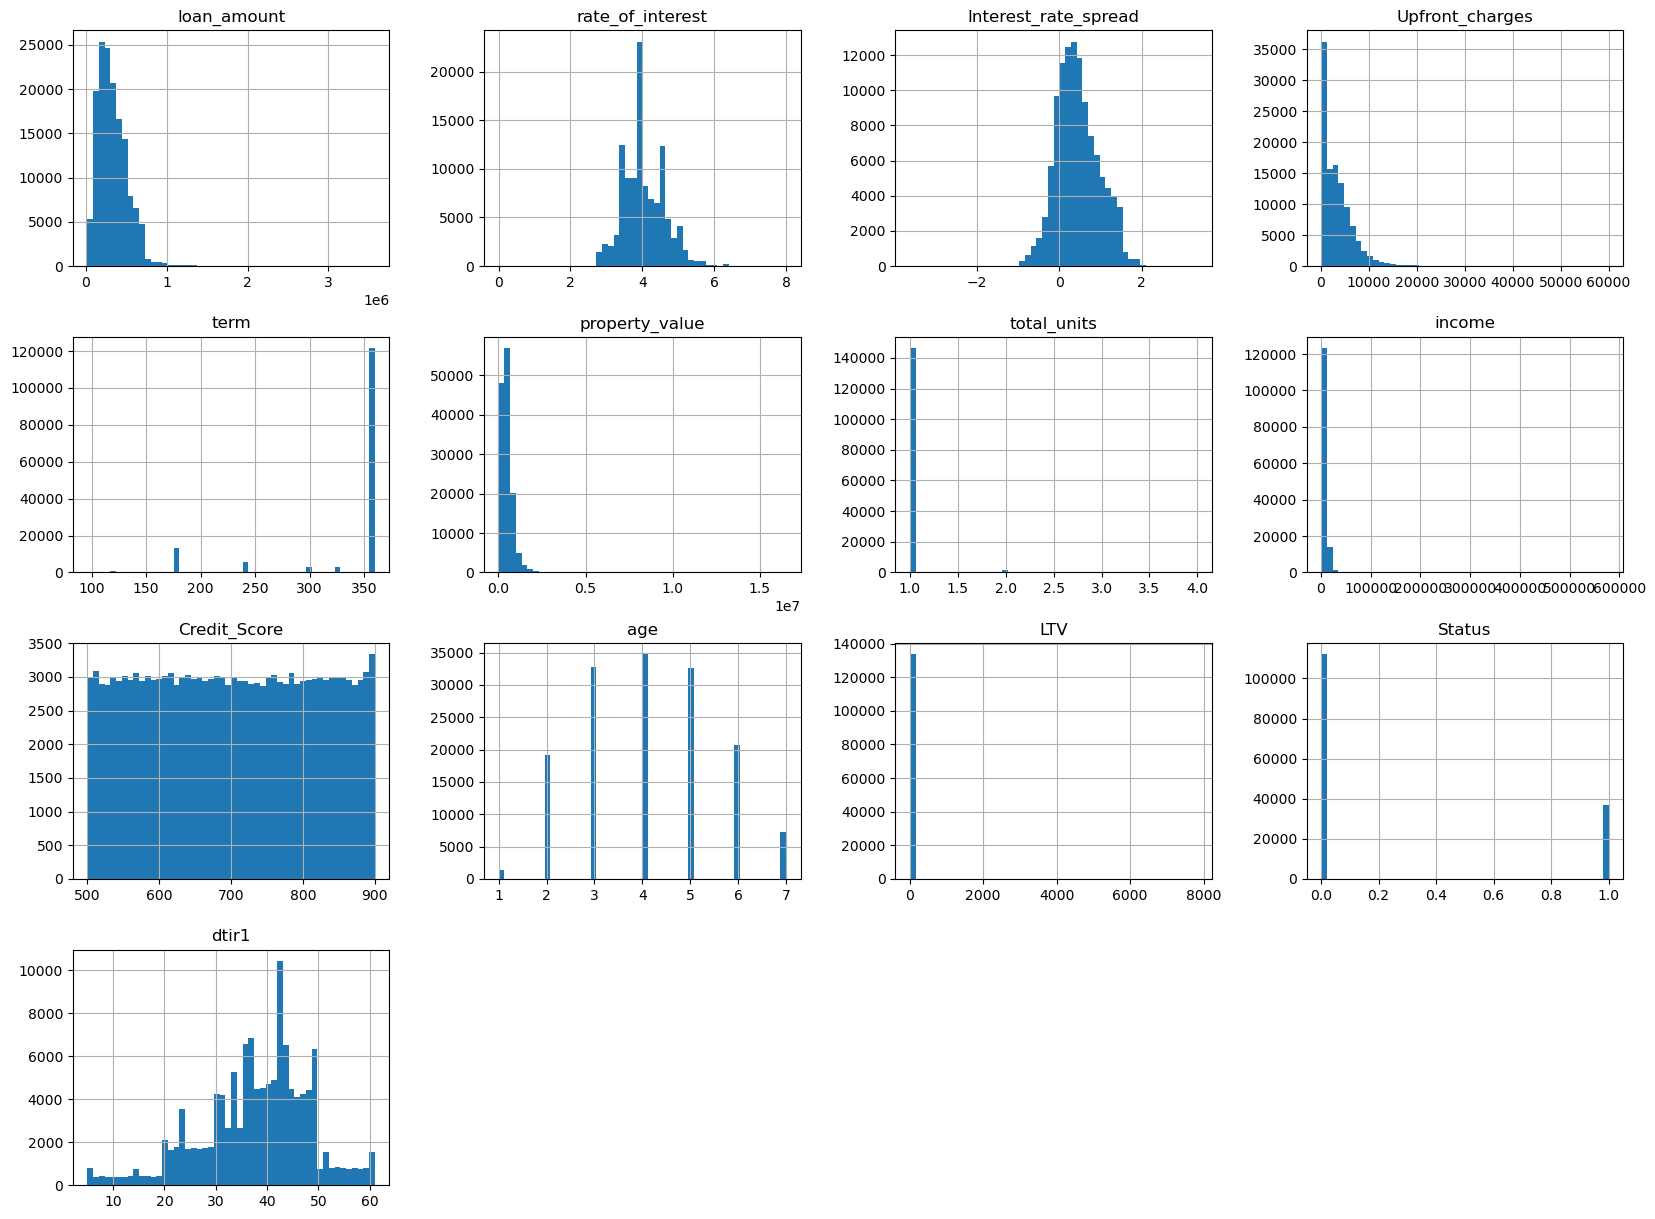

In [12]:
#plot the histograms
loan_data.hist(bins=50, #number of bins to encapsulate the data
               figsize=(20,15)
              );

**Notice:** There are some capped values, specifically concerning: 
- term
- dtir1
- Credit_Score

**`term`** feature for sure is capped at: $360$. Probably also: **`dtir1`** and **`Credit_Sore`**, were capped but with a lower impact.\
In any case, since they are not our target attributes, this is not a big issue and we can actually ignore it.

In [13]:
loan_data.corr()["Status"].sort_values(ascending=False) #correlation related to out target

Status                  1.000000
dtir1                   0.078083
age                     0.044600
LTV                     0.038895
total_units             0.023800
rate_of_interest        0.022957
Credit_Score            0.004004
term                   -0.000240
Upfront_charges        -0.019138
loan_amount            -0.036825
property_value         -0.048864
income                 -0.065119
Interest_rate_spread         NaN
Name: Status, dtype: float64

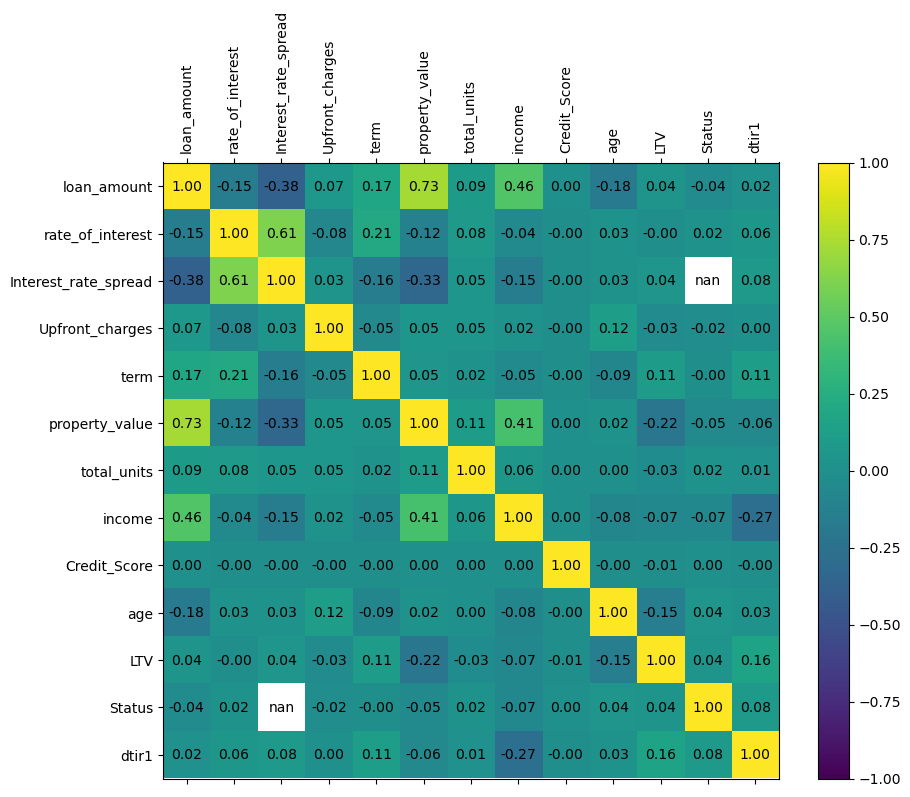

In [14]:
#compute the correlations
correlations = loan_data.corr()

#plot
fig = plt.figure(figsize=(10, 8)) 
ax = fig.add_subplot(111) 
cax = ax.matshow(correlations, 
                 vmin=-1, 
                 vmax=1) 
fig.colorbar(cax) 
ticks = np.arange(len(numerical_ordinal_columns)) 
ax.set_xticks(ticks) 
ax.set_yticks(ticks) 
ax.set_xticklabels(numerical_ordinal_columns, 
                   rotation=90) #to see the column lables clearly
ax.set_yticklabels(numerical_ordinal_columns) 

# Annotate cells with correlation values
for i in range(len(correlations)):
    for j in range(len(correlations)):
        value = correlations.iloc[i, j]
        ax.text(j, 
                i, 
                f'{value:.2f}', 
                va='center', 
                ha='center', 
                color='black')
        
plt.show()

**Notice:** the correlation coefficient between **`Status`** and **`interest_rate_spread`** returns not a number, this is due to the fact that the latter feature is actually compromised, (we will see in few block codes how), furthermore the two standard deviations are very tiny.

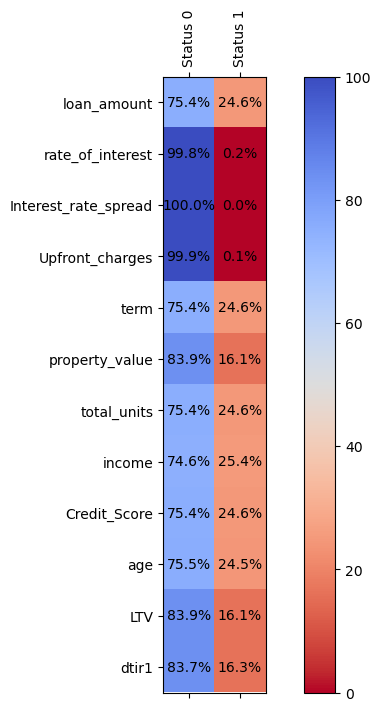

In [15]:
#showing the percentages of data grouped by target values
def compute_feature_target_percentages(df, features, target='Status'):
    rows = []
    for feat in features:
        #Discharge NaN values for feature and target
        feature_data = df[[feat, target]].dropna()

        #total valid values for this feature
        total = len(feature_data)

        #How many of these are target=0 and target=1
        count_0 = feature_data[feature_data[target] == 0].shape[0]
        count_1 = feature_data[feature_data[target] == 1].shape[0]

        #we translate the above data into percentages
        pct_0 = (count_0 / total) * 100 if total > 0 else 0
        pct_1 = (count_1 / total) * 100 if total > 0 else 0

        rows.append({'feature': feat, 
                     'target=0 %': pct_0, 
                     'target=1 %': pct_1})
    return pd.DataFrame(rows)

result = compute_feature_target_percentages(loan_data, numerical_ordinal_features)

#Extract data and labels
data_matrix = result[['target=0 %', 
                      'target=1 %']].to_numpy()
feature_labels = result['feature'].tolist()
target_labels = ['Status 0', 
                 'Status 1']

#Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
cax = ax.matshow(data_matrix, 
                 vmin=0, 
                 vmax=100, 
                 cmap='coolwarm_r')
fig.colorbar(cax)

#Ticks
ax.set_xticks(np.arange(len(target_labels)))
ax.set_yticks(np.arange(len(feature_labels)))
ax.set_xticklabels(target_labels, 
                   rotation=90)
ax.set_yticklabels(feature_labels)

#Values
for i in range(data_matrix.shape[0]):
    for j in range(data_matrix.shape[1]):
        value = data_matrix[i, j]
        ax.text(j, 
                i, f'{value:.1f}%', 
                va='center', 
                ha='center', 
                color='black')
plt.show()

**Notice:** it is important to point out that through the notebook we adopted the following convention:
- **`Status=0`**, *i.e.:* loan totally repaid, is chosen as the ***negative*** case
- **`Status=1`**, *i.e.:* loan not repaid, is chosen as the ***positive*** case

This is due to the general rule that the *positive* class should be the one of interest, so the event that we want to detect, indeed for us it is important to detect the default client.

Due to what we saw in section: [2.2. Missing Values](#NaN--2-2), we can say that: **`rate_of_interest`**, **`Interest_rate_spread`** and **`Upfront_charges`**, when they are not missing they are nearly always with **`Status=0`**. We must drop them entirely from the whole dataset, because they are not meaningful and they have also the highest misses.

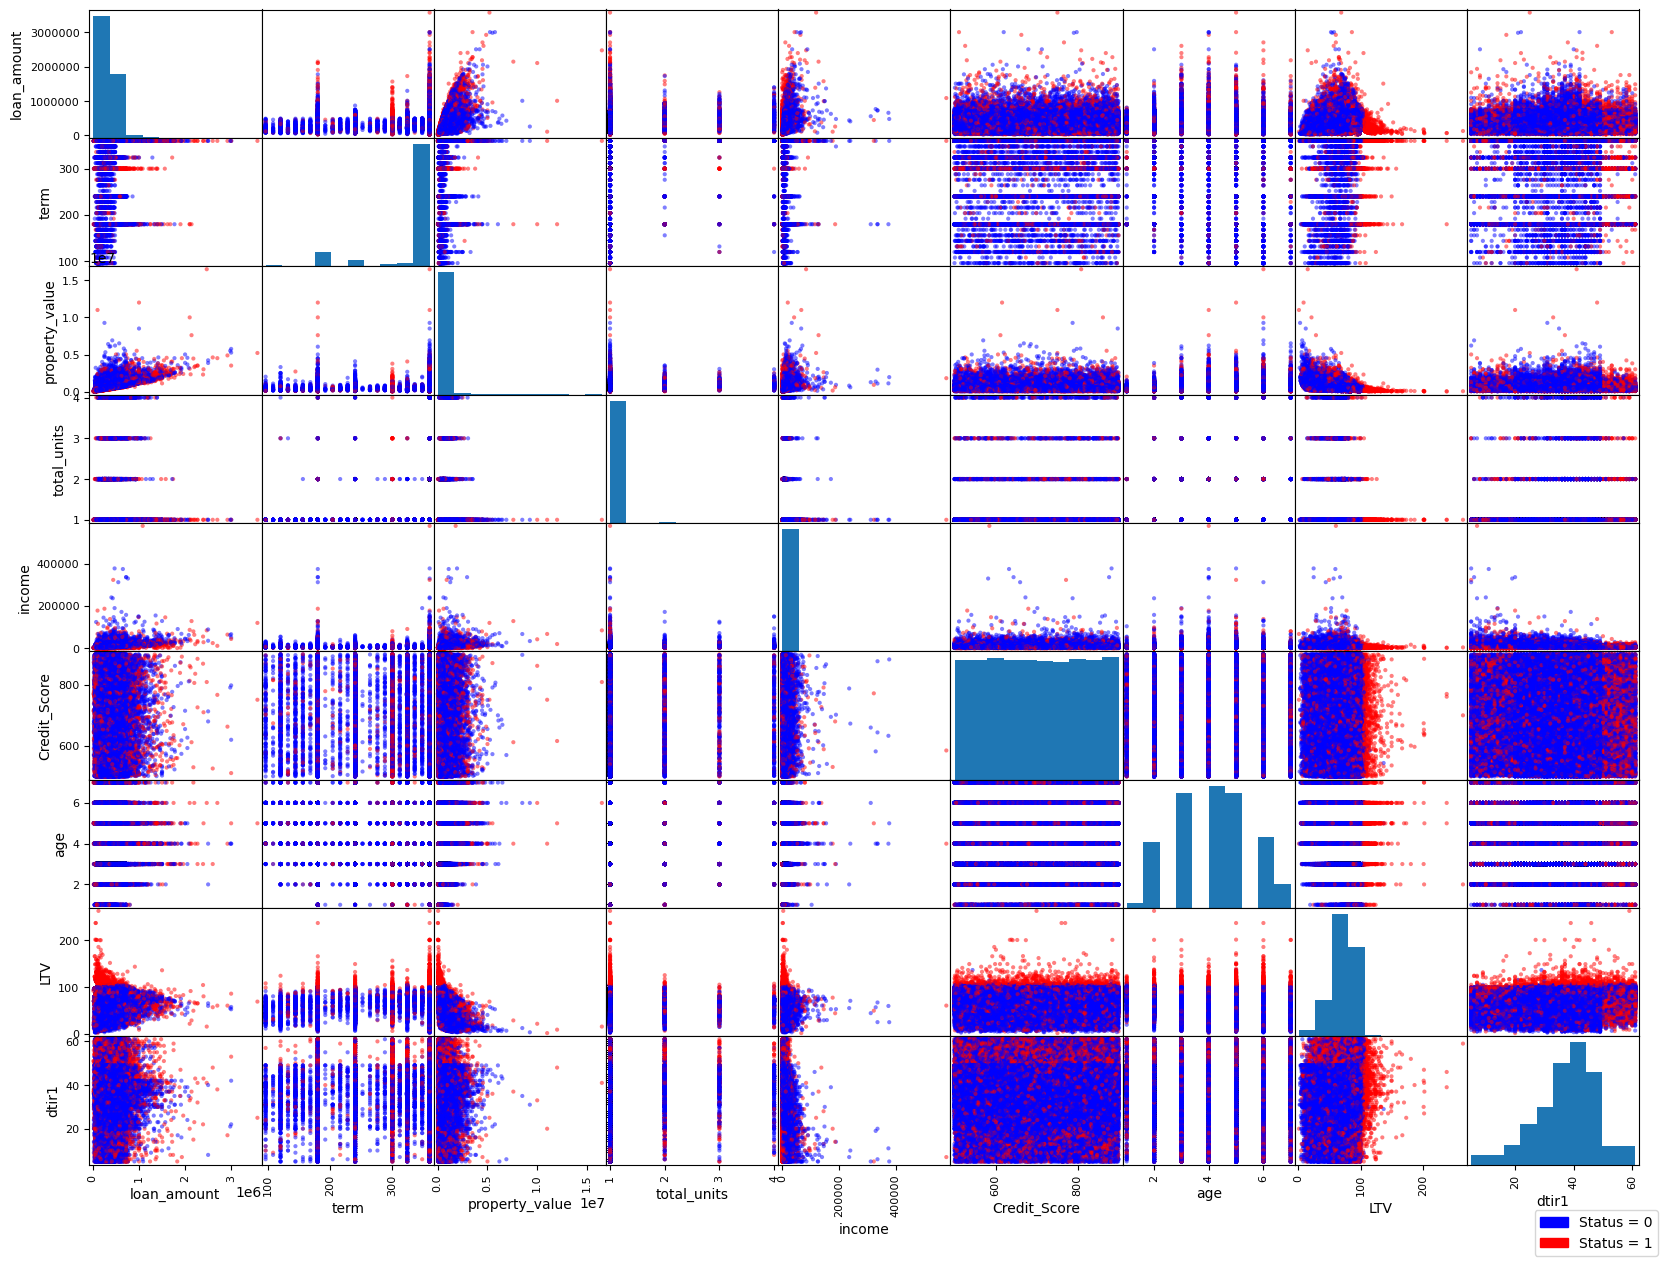

In [16]:
#discharge the not desired columns
data = loan_data.drop(['rate_of_interest', 
                       'Interest_rate_spread', 
                       'Upfront_charges'], 
                      axis=1)

#discharge the rows without elements
data = data.dropna()

#prepare the colors based on the Status (0 o 1)
color_map = {0: 'blue', 
             1: 'red'
            }
colors = data['Status'].map(color_map)

# Plot dello scatter_matrix
pd.plotting.scatter_matrix(data.drop(columns=['Status']),
                            figsize=(20, 15),
                            diagonal='hist',
                            color=colors,
                            alpha=0.5
            )

#patch for the legend
legend_handles = [mpatches.Patch(color='blue', 
                               label='Status = 0'
                              ),
                  mpatches.Patch(color='red', 
                               label='Status = 1'
                              )
                ]

plt.legend(handles=legend_handles, 
           loc='upper right', 
           bbox_to_anchor=(1.15, -0.3)
          )
plt.show()

**Notice:** grouping dots based on the the target condition is very helpful for data visualization, there is a Python library for data visualization [Seaborn](https://seaborn.pydata.org/) <a name="cite_ref-2"></a>[<sup>*</sup>](#cite_note-2) that allows to plot directly these types of graphs in a very straightforward way, but it is a more computational expensive tool, that in cases of big datasets can slow down the process a lot, this is the reason why we implemented the solution using **`matplotlib`** in a longer way.

<a name="cite_note-2"></a> [*](#cite_ref-2): [Here](https://github.com/fraro01/Engine-vibrations-among-x-y-z-axes/blob/main/Engine%20Failure%20Detection.ipynb) is a project of mine with an implention using Seaborn

### General Categorical and Binary Categorical Data <a name="CategoricalData--2-4"></a>

**Notice:** in the following block of code, we decided to transform manually the binary categorical data in binary ordinal data, assigning $0$ or $1$ with the following concept: $0$ whether the associated variable has lower probability of deafult, $1$ viceversa. (where possible).

In [17]:
#convert all the categorical binary columns to ordinal binary
loan_data['loan_limit'] = loan_data['loan_limit'].map({'cf': 1,'ncf': 0})
loan_data['approv_in_adv'] = loan_data['approv_in_adv'].map({'nopre': 1,'pre': 0})
loan_data['Credit_Worthiness'] = loan_data['Credit_Worthiness'].map({'l2': 1,'l1': 0})
loan_data['open_credit'] = loan_data['open_credit'].map({'opc': 1,'nopc': 0})
loan_data['business_or_commercial'] = loan_data['business_or_commercial'].map({'b/c': 1,'nob/c': 0})
loan_data['Neg_ammortization'] = loan_data['Neg_ammortization'].map({'not_neg': 1,'neg_amm': 0})
loan_data['interest_only'] = loan_data['interest_only'].map({'not_int': 1,'int_only': 0})
loan_data['lump_sum_payment'] = loan_data['lump_sum_payment'].map({'not_lpsm': 1,'lpsm': 0})
loan_data['construction_type'] = loan_data['construction_type'].map({'sb': 1,'mh': 0})
loan_data['Secured_by'] = loan_data['Secured_by'].map({'home': 1,'land': 0})
loan_data['co-applicant_credit_type'] = loan_data['co-applicant_credit_type'].map({'CIB': 1,'EXP': 0})
loan_data['submission_of_application'] = loan_data['submission_of_application'].map({'to_inst': 1,'not_inst': 0})
loan_data['Security_Type'] = loan_data['Security_Type'].map({'direct': 1,'Indriect': 0})

In [18]:
#list of categorical non-binary columns
cat_columns = ['Gender', 
               'loan_type', 
               'loan_purpose', 
               'occupancy_type', 
               'credit_type', 
               'Region']

# Loop through each column
for col in cat_columns:
    encoder = OneHotEncoder(sparse=False, 
                            handle_unknown='ignore')  #new encoder for each
    encoded_array = encoder.fit_transform(loan_data[[col]])
    encoded_df = pd.DataFrame(encoded_array, 
                              columns=encoder.get_feature_names_out([col]),
                              index=loan_data.index)
    
    # Drop original column and concatenate the encoded DataFrame
    loan_data.drop(columns=[col], 
                   inplace=True)
    loan_data = pd.concat([loan_data, 
                           encoded_df
                          ], 
                          axis=1)

In [19]:
#list of all categorical columns
categorical_columns = [
                      'loan_limit', 
                      'approv_in_adv',
                      'Credit_Worthiness',
                      'open_credit',
                      'business_or_commercial',
                      'Neg_ammortization',
                      'interest_only',
                      'lump_sum_payment',
                      'construction_type',
                      'Secured_by',
                      'co-applicant_credit_type',
                      'submission_of_application',
                      'Security_Type',
                      'Gender_Male', 'Gender_Joint', 'Gender_Sex Not Available', 'Gender_Female', 
                      'loan_type_type1', 'loan_type_type2', 'loan_type_type3',  
                      'loan_purpose_p3', 'loan_purpose_p4', 'loan_purpose_p1', 'loan_purpose_p2', 
                      'occupancy_type_pr', 'occupancy_type_ir', 'occupancy_type_sr', 
                      'credit_type_CIB', 'credit_type_CRIF', 'credit_type_EXP', 'credit_type_EQUI', 
                      'Region_North', 'Region_south', 'Region_central', 'Region_North-East',
                      'Status'
                    ]


categorical_features = categorical_columns.copy()
#list of all categorical features
categorical_features.remove('Status')

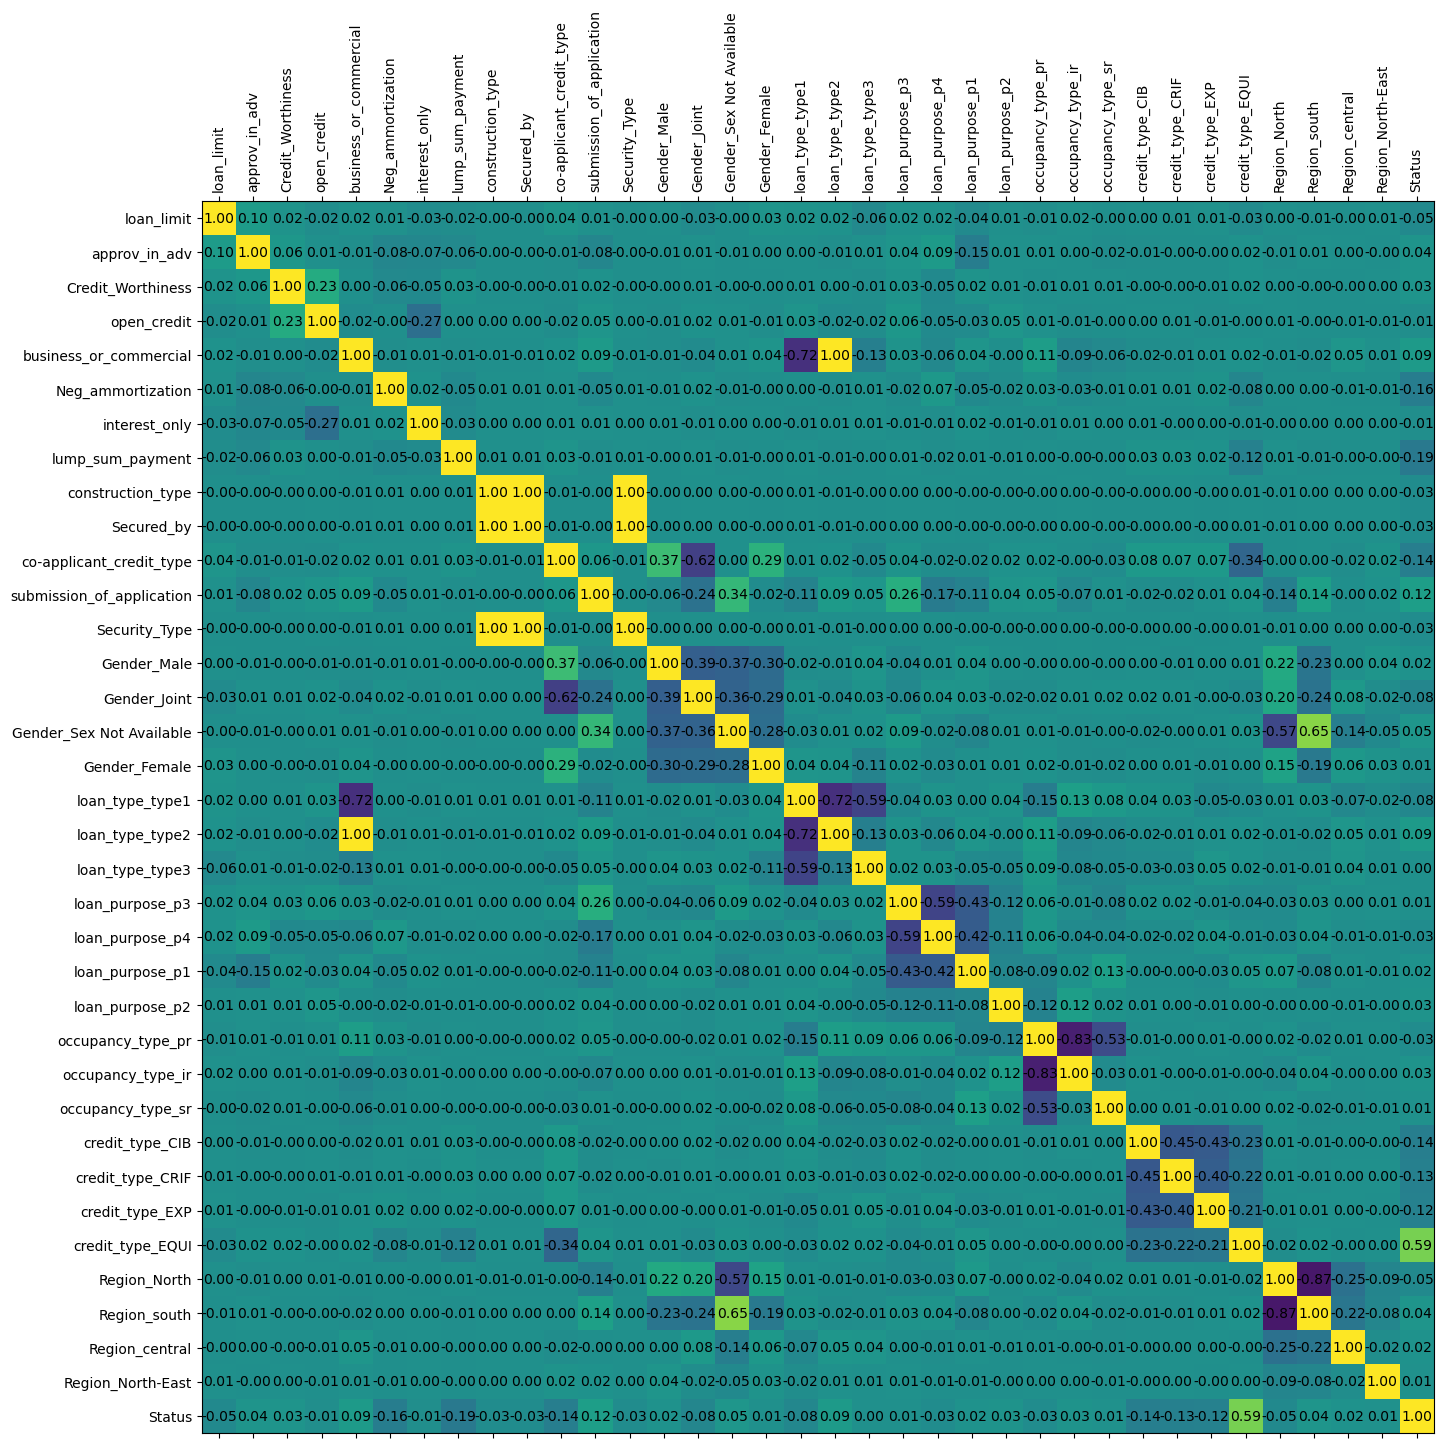

In [20]:
binary_correlation = loan_data[categorical_columns].corr()

#plot
fig = plt.figure(figsize=(20, 16)) 
ax = fig.add_subplot(111) 
cax = ax.matshow(binary_correlation, 
                 vmin=-1, 
                 vmax=1) 

ticks = np.arange(len(categorical_columns)) 
ax.set_xticks(ticks) 
ax.set_yticks(ticks) 
ax.set_xticklabels(categorical_columns, 
                   rotation=90) #to see the column lables clearly
ax.set_yticklabels(categorical_columns) 

#annotate cells with correlation values
for i in range(len(binary_correlation)):
    for j in range(len(binary_correlation)):
        value = binary_correlation.iloc[i, j]
        ax.text(j, 
                i, 
                f'{value:.2f}', 
                va='center', 
                ha='center', 
                color='black')
        
plt.show()

Pandas **`dataframe.corr()`** method computes the Pearson's correlation coefficient:

$$ \rho_{x,y} = \frac{cov(X,Y)}{\sigma_X\sigma_Y} $$

where:
- $cov$ is the covariance computed as: $cov(X,Y) \ = \ \mathbb{E}[(X-\mu_X)(Y-\mu_Y)]$
- $\sigma_X$ is the standard deviation of $X$
- $\sigma_Y$ is the sandard deviation of $Y$

In the case of binary variables that assume only values in $\{0,1\}$, using Pearson's coefficient is a possible way to gain an overview of the correlation between variables [ResearchGate correlation of binary data](https://www.researchgate.net/post/Correlation_of_binary_data).\
Keep in mind that in literature there many other methods to achieve so, such as: point-biserial correlation coefficient, Spearman's correlation coefficient.

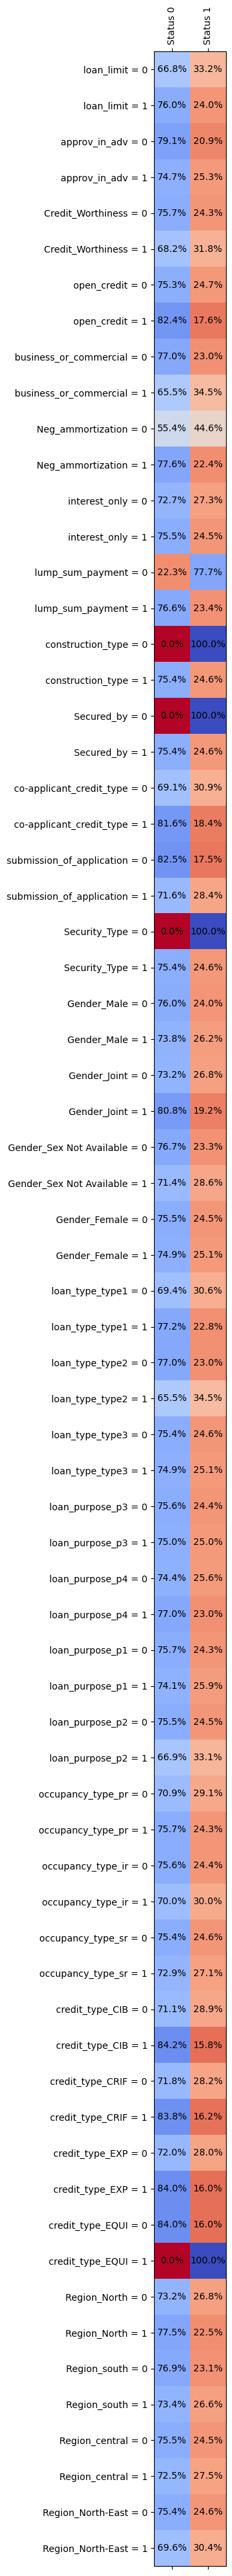

In [21]:
def compute_binary_feature_target_distribution(df, binary_features, target='Status'):
    rows = []
    for feat in binary_features:
        for val in [0, 1]:
            #filter for feature value
            subset = df[(df[feat] == val) & (df[target].isin([0, 1]))]

            total = len(subset)
            count_0 = subset[subset[target] == 0].shape[0]
            count_1 = subset[subset[target] == 1].shape[0]

            pct_0 = (count_0 / total) * 100 if total > 0 else 0
            pct_1 = (count_1 / total) * 100 if total > 0 else 0

            rows.append({
                'feature': feat,
                'value': val,
                'Status 0 %': pct_0,
                'Status 1 %': pct_1
            })
    return pd.DataFrame(rows)


result_bin = compute_binary_feature_target_distribution(loan_data, categorical_features)

#extract data for heatmap
data_matrix = result_bin[['Status 0 %', 'Status 1 %']].to_numpy()
row_labels = [f"{f} = {v}" for f, v in zip(result_bin['feature'], result_bin['value'])]
col_labels = ['Status 0', 'Status 1']

#plot
fig = plt.figure(figsize=(15, len(row_labels) * 0.7))
ax = fig.add_subplot(111)
cax = ax.matshow(data_matrix, 
                 vmin=0, 
                 vmax=100, 
                 cmap='coolwarm_r')
# ticks
ax.set_xticks(np.arange(len(col_labels)))
ax.set_yticks(np.arange(len(row_labels)))
ax.set_xticklabels(col_labels, rotation=90)
ax.set_yticklabels(row_labels)

#annotate values
for i in range(data_matrix.shape[0]):
    for j in range(data_matrix.shape[1]):
        value = data_matrix[i, j]
        ax.text(j, 
                i, 
                f'{value:.1f}%', 
                va='center', 
                ha='center', 
                color='black')
        
plt.show()

## 3. Data Preprocessing <a name="DataPreprocessing--3"></a>

So far we have handled the whole dataset manually in order to better manipulate it and visualize relevant characteristics.\
In machine learning, it is way better to use **pipelines**, which are automated and organized series of steps that orchestrate the entire machine learning lifecycle, from data collection and preprocessing to model training, validation, and deployment.

In [22]:
#import of packages and libraries useful for fitting, transforming hence pipelines
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
import warnings #for ignoring the warnings while the models run

In [23]:
#while running some code blocks we encounter some useless warnings that in production we can ignore for a tidier code
#ignore the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)
#ignore the UserWarning
#warnings.filterwarnings("ignore", category=UserWarning)

In [24]:
#features are now only numerical and ordinal, the number of them increased, as the memory usage increased by: 17+ MB
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 49 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  float64
 1   approv_in_adv              147762 non-null  float64
 2   Credit_Worthiness          148670 non-null  int64  
 3   open_credit                148670 non-null  int64  
 4   business_or_commercial     148670 non-null  int64  
 5   loan_amount                148670 non-null  int64  
 6   rate_of_interest           112231 non-null  float64
 7   Interest_rate_spread       112031 non-null  float64
 8   Upfront_charges            109028 non-null  float64
 9   term                       148629 non-null  float64
 10  Neg_ammortization          148549 non-null  float64
 11  interest_only              148670 non-null  int64  
 12  lump_sum_payment           148670 non-null  int64  
 13  property_value             13

**Notice:** the memory usage given directly by Pandas has increased by 17+ MB, due to the transformation into ordinal data.\
In order to have a clearer idea of the actual memory used, as already mentioned in section [2.1. Dataset Description](#DatasetDescription--2-1), we should use **`sys.gestsizeof()`** as below.

In [25]:
#the result is in bytes
sys.getsizeof(loan_data)

58278784

The number shows that actually the memory used is way less with respect to the beginning, this is due to the fact that integer objects take less memory compared to string objects.

Since we want to embrace the *pipeline* approach, **we drop the previous manually manipulated dataset, and we take a new one, as it follows.**

In [26]:
try:
    loan_data = pd.read_csv(path + '\Loan_Default.csv')
    
except:
    loan_data = pd.read_csv('Loan_Default.csv') #if something goes wrong. use the copy of the dataset in the folder

In the following code block we apply column removal, based on the characteristics that emerged in sections [2.3.](#NumericalAndOrdinalData--2-3) and [2.4.](#CategoricalData--2-4).\
It is important to point out that the column removal has been applied on the whole dataset, because the criticalities on those features were so strong that allowed us to procede without compromising the effectiveness of the test set.\
In order to better explain how the decisions have been taken we divide the data into numerical and categorical:

- **Numerical**:
    - **`ID`**, **`year`**: have been removed since they did not bring any relevant information for predictive purposes.
    - **`rate_of_interest`**,**`Interest_rate_spread`**,**`Upfront_charges`**: have been removed, because they were strongly compromised, they have the highest missing values and furthermore whenever they are not missing, the target is nearly always: **`Status=0`**

- **Categorical**:
    - **`business_or_commercial`**: has been removed because from the correlation matrix emerges that is strongly correlated to **`loan_type_2`**
    - **`Secured_by`**, **`Security_Type`**: have been removed because from the correlation matrix emerged that they were strongly correlated to each other and to **`construction_type`**, furthermore whenever **`Secured_by=land`** or **`Security_Type=indirect`** the target always assumes: **`Status=1`**
    - When the feature **`credit_type`** assumes the value **`EQUI`**, the target is always **`Status=1`**, in this situation it is spuriously predictive. It is a case of [data leakage](#https://en.wikipedia.org/wiki/Leakage_(machine_learning)), by removing it, we prevent the model from learning this allegedly wrong pattern. **`credit_type`** is later transformed with one-hot encoding, because it can assume four different values, so we decided to set it to **`NaN`** whenever it assumes **`EQUI`**. Later, when the models call the *fit* of the *pipeline* on only the training set, the **`NaN`** will be replaced with the most frequent category.
    
It is important to point out that the threshold of correlation by which we decided to remove columns has been set to $0.90$ since decision trees and even better ensemble learning algorithms are quite robust when they face correlation.

In [27]:
#removing the non-relevant features
loan_data = loan_data.drop([#numerical
                          'ID',          
                          'year',
                          'rate_of_interest', 
                          'Interest_rate_spread', 
                          'Upfront_charges',
                           #categorical
                          'Security_Type',
                          'Secured_by',
                          'business_or_commercial',
                             ],
                             axis=1
                            )

#setting to NaN the non-relevant columns
loan_data.loc[loan_data['credit_type'] == 'EQUI', 'credit_type'] = np.nan

In [28]:
#map for the ordinal mapping of age groups
age_mapping = {'<25': 1,
                '25-34': 2,
                '35-44': 3,
                '45-54': 4,
                '55-64': 5,
                '65-74': 6,
                '>74': 7
                }
#map for the ordinal mapping of the total_units
total_units_mapping = {'1U': 1,
                    '2U': 2,
                    '3U': 3,
                    '4U': 4
                }

#list of the names of the ordinal features
ordinal_features = ['age', 
                'total_units',
               ]
#list of the names of the categorical features where we will apply OneHotEncoding
onehot_features = ['loan_limit', 
               'approv_in_adv',
               'Credit_Worthiness',
               'open_credit',
               'Neg_ammortization',
               'interest_only',
               'lump_sum_payment',
               'construction_type',
               'co-applicant_credit_type',
               'submission_of_application',
               'Gender', 
               'loan_type', 
               'loan_purpose', 
               'occupancy_type', 
               'credit_type', 
               'Region',
              ]
#list of the numerical features
numerical_features = ['loan_amount',
                     'term',
                     'property_value',
                     'income',
                     'Credit_Score',
                     'LTV',
                     'dtir1'    
                    ]

In [29]:
# Categorical one-hot
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')) #we ignore the unknown cathegory setting to zeros, best-practice 
])

# Numerical
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

# Ordinal
#age ordinal pipeline
age_pipeline = Pipeline([
    ('mapper', FunctionTransformer(
        lambda x: x.iloc[:, 0].map(age_mapping).to_frame(), #anonymous function, thanks to which we map the 'age' column to
        validate=False)),                                   #the mapping we have previously defined, in a DataFrame format
    ('imputer', SimpleImputer(strategy='most_frequent'))
])
#total_units ordinal pipeline
total_units_pipeline = Pipeline([
    ('mapper', FunctionTransformer(
        lambda x: x.iloc[:, 0].map(total_units_mapping).to_frame(), 
        validate=False)), #since we want to work with DataFrame we must set validate to False
    ('imputer', SimpleImputer(strategy='most_frequent'))
])

#Full pipeline, merging all type of data
preprocessor = ColumnTransformer([
    ('cat_onehot', cat_pipeline, onehot_features),
    ('num', num_pipeline, numerical_features),
    ('age_ord', age_pipeline, ['age']), #since ColumnTransformer apply transformations on list of columns we must give list
    ('units_ord', total_units_pipeline, ['total_units']),
    
])

In [30]:
#memory usage in bytes of the processed dataset with the pipeline
sys.getsizeof(preprocessor.fit_transform(loan_data))

59468120

**Notice:** now that we have applied the **`preprocessor`** (that is a pipeline for column transformation) to the original dataset, we see that the memory used is again way less with respect to the original one, buth slightly more compared to the manually transformed dataset obtained at the end of section [2.](#DatasetImport--2) (that contained $49$ columns), even though now we have removed nine features.\
This is simply due to the fact that with the **`preprocessor`** the one-hot encoding is fully applied to all categorical data (except: **`age`**, **`total_units`**), resulting with $50$ columns.

## 4. Training the Models <a name="TrainingTheModels--4"></a>

In [31]:
#import of all libraries and packages
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from xgboost import XGBClassifier #XGBoostClassifier
from sklearn.ensemble import AdaBoostClassifier #AdaBoost
from sklearn.tree import DecisionTreeClassifier #for AdaBoost
from sklearn.ensemble import GradientBoostingClassifier #GradientBoost
#instead of Joblib, we use Cloudpickle, since it is able to save also the lambda functions
import cloudpickle #for saving the models
#for getting all the metrics and displaying them
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, average_precision_score, PrecisionRecallDisplay, accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
import time #for counting the amount of time it takes for the algorithm to run

In [32]:
#for converting seconds into readable format, for the runtime
def convert_time(seconds):
    seconds = seconds % (24 * 3600)
    hour = seconds // 3600
    seconds %= 3600
    minutes = seconds // 60
    seconds %= 60
    
    return "%d:%02d:%02d" % (hour, minutes, seconds)

In [33]:
#Separate features and target
X = loan_data.drop(columns=['Status'])
y = loan_data['Status']

#split the dataset into train and test sets, with a proportion of 90-10%, since we have 148670 samples.
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.10, 
                                                    random_state=42,
                                                    stratify=y, #in order to keep the splits balanced
                                                   )


#stratified K-Fold for balanced class distribution over the target
strat_kfold = StratifiedKFold(n_splits=5, #number of folds
                              shuffle=True, #before creating the fold, it shuffles the rows (samples)
                              random_state=42, #footnote following block
                             )

**Notice:** our dataset is a bit unbalanced in terms of target values, since the samples with **`Status=0`** are way more than the ones with **`Status=1`**, this can lead to slighlty biased models. In order to overcome this issue we tweak some models' paramaters accordingly.

This practice is especially useful for improving the **`recall`** of our models.

$$ Recall = \frac{\text{True Positives}}{\text{True Positives}\ +\ \text{False Negatives}} $$

As opposed to:

$$ Precision = \frac{\text{True Positives}}{\text{True Positives}\ +\ \text{False Positives}} $$

Since credit institutes tend to be risk adverse in front of potential loan clients, they ***prefer recall over precision***, and this is the way we approach our three following models.

<br/>

<span style="font-size:80%"> **`random_state = 42`** is an inside joke of machine learning base on the famous book: *The Hitchhiker's Guide to the Galaxy, Douglas Adams*, [see](https://grsahagian.medium.com/what-is-random-state-42-d803402ee76b) </span> 

### 4.1. eXtreme Gradient Boosting <a name="XGBoosting--4-1"></a>

In [34]:
#counting the number of positive and negative samples for balancing the model
num_negatives = loan_data['Status'].value_counts()[0]
num_positives = loan_data['Status'].value_counts()[1]

In [85]:
"""
Notice, if you do not have enough time, you can skip directly to the following cell, if you already have the proper pkl
object in your folder, since it will open the already trained model.
"""

#setting the XGBoost classifier
xgb_model = XGBClassifier(eval_metric='logloss',
                          random_state=42, #to control the internal random components of the classifier 
                          scale_pos_weight = num_negatives / num_positives #it gives more weight to the positive samples
                         )                                                 #since they are less, in order to overcome
                                                                           #unbalanced dataset
#adding to the pipeline the algorithm
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb_model)
])

#parameter grid for GridSearch
param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [6, 7, 9],
    'classifier__learning_rate': [0.01, 0.1, 0.3],
    'classifier__subsample': [0.8, 1],  #fraction of samples used for fitting each tree (classic XGBoosting Vs Stochastic)
}

# Grid search setup
grid_search_XGBoost = GridSearchCV(full_pipeline, 
                           param_grid, 
                           cv=strat_kfold, 
                           n_jobs=-1, #it uses all the CPU cores availbale in parallel 
                           verbose=2, #it shows all details for each combination 
                           scoring = 'recall', #since we want prioritize recall
                           #scoring = 'f1',     
                                  )

start_time = time.time() #for counting the time
# Fit GridSearchCV on training data
grid_search_XGBoost.fit(X_train, 
                y_train
               )
end_time = time.time() #end time of execution
elapsed_time = convert_time(end_time - start_time)
print(f"XGBoosting training + grid search took {elapsed_time}")

# Best params and score
print("Best parameters found:", grid_search_XGBoost.best_params_)
print("Best cross-validation Recall:", grid_search_XGBoost.best_score_)

# Optional: Evaluate on the test set
test_score = grid_search_XGBoost.score(X_test, y_test)
print(f"Test set Recall: {test_score:.4f}") #we print the accuracy with the four decimals

Fitting 5 folds for each of 54 candidates, totalling 270 fits
XGBoosting training + grid search took 0:28:34
Best parameters found: {'classifier__learning_rate': 0.3, 'classifier__max_depth': 6, 'classifier__n_estimators': 100, 'classifier__subsample': 0.8}
Best cross-validation F1-score: 0.7243669446550417
Test set F1-score: 0.7415


In [36]:
#try to see whether the above cell has been run
try: 
    grid_search_XGBoost
    recovered = False #boolean variable to understand wheter the model has been recovered from serialization or not
    
#otherwise open the serialized model
except:
    with open("XGBoost_loan.pkl", mode="rb") as f: #rb stands for reading binary
        grid_search_XGBoost = cloudpickle.load(f)
    recovered = True

In [86]:
pd.DataFrame(grid_search_XGBoost.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       14.002135      1.064122         0.951603        0.031143   
1       12.234674      1.699613         0.817639        0.053409   
2       24.129124      2.048963         1.091664        0.147554   
3       16.996836      0.178331         0.944936        0.041091   
4       28.527396      0.775206         1.255945        0.099320   
5       23.748927      0.415055         1.183722        0.064522   
6       13.017980      0.440556         0.839997        0.070214   
7       12.717729      0.973526         1.163213        0.303758   
8       23.706424      3.760280         1.138339        0.226610   
9       26.845938      1.895148         1.493173        0.316415   
10      49.134033      7.877353         2.178341        0.847472   
11      35.161103      4.793060         2.103027        0.076824   
12      24.305480      2.125421         1.403352        0.277346   
13      20.364660      3.561149         1.256349        0.171653   
14      32.739851      2.202724         1.662664        0.279176   
15      25.757624      1.704913         1.516631        0.160898   
16      43.778123      2.180284         1.949141        0.058734   
17      37.696899      1.602213         2.535586        0.729581   
18      13.253292      0.408151         0.934952        0.122780   
19      10.174683      0.478413         0.771980        0.081516   
20      20.082728      0.430728         1.080132        0.137869   
21      15.536832      0.206567         1.004918        0.086182   
22      26.936594      0.353218         1.246156        0.090568   
23      20.617347      0.304748         1.232912        0.064190   
24      12.239073      0.098642         0.819802        0.053047   
25      10.527366      0.111746         0.806254        0.057108   
26      19.759642      0.353169         1.089457        0.059198   
27      16.571811      0.211726         1.092560        0.051912   
28      28.196995      0.173767         1.400117        0.058182   
29      21.972461      0.177224         1.350506        0.036344   
30      14.289603      0.069831         0.936906        0.038935   
31      12.456610      0.166919         0.930428        0.032762   
32      25.472924      0.881606         1.612585        0.110145   
33      20.418698      0.651902         1.338875        0.019142   
34      36.393363      1.247437         1.868834        0.054793   
35      27.071108      0.956172         1.826693        0.218825   
36      11.944596      0.703988         0.839406        0.187144   
37      11.208294      0.577049         0.812813        0.130653   
38      20.935893      3.198659         1.768035        0.777512   
39      20.254853      1.425757         1.080103        0.064145   
40      28.519653      3.477360         1.167134        0.046086   
41      22.015012      2.382834         1.323819        0.166034   
42      14.980176      1.192060         0.952879        0.095822   
43      11.224722      0.335491         0.912361        0.118329   
44      30.593378      1.066664         1.793186        0.807902   
45      25.997594      2.063825         2.029269        0.588399   
46      40.664634      4.395950         1.748777        0.208086   
47      25.903085      1.221499         1.751952        0.209697   
48      20.529347      0.787489         1.254276        0.170255   
49      14.667325      0.842856         1.133376        0.188128   
50      27.235754      0.789389         1.481966        0.032418   
51      22.167926      0.527899         1.470356        0.076796   
52      40.734799      0.373828         2.052285        0.036929   
53      29.021482      2.413461         1.798623        0.310179   

   param_classifier__learning_rate param_classifier__max_depth  \
0                             0.01                           6   
1                             0.01                           6   
2                             0.01                           6   

In [87]:
#we encapsulate just the best model
XGBoost_whole_model = grid_search_XGBoost.best_estimator_ #here we save the whole best model full pipeline (prepocessor + classifier)
XGBoost_classifier = XGBoost_whole_model.named_steps['classifier'] #here we save just the best classifier

In [88]:
#recover just the preprocessor from the whole model
preprocessor = XGBoost_whole_model.named_steps['preprocessor']
feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    #if the transformer is a drop operator
    if transformer == 'drop':
        continue
    #if the transformer is actually a pipeline object, so that has inside other transformers
    if isinstance(transformer, Pipeline):
        #get the last step of the pipeline, because the last step is the one that finally transforms the data and generates new names
        last_step = transformer.steps[-1][1]
        if hasattr(last_step, 'get_feature_names_out'):
            names = last_step.get_feature_names_out(cols)
        else:
            names = cols
    #if the transformer is directly a transformer
    else:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
    
    feature_names.extend(names)

feat_imp = pd.DataFrame({
                        'feature': feature_names,
                        'importance': XGBoost_classifier.feature_importances_
                        }).sort_values(
                                        by="importance", 
                                        ascending=False
                                        )

print(feat_imp)

                               feature  importance
12               lump_sum_payment_lpsm    0.170821
34                     credit_type_CIB    0.092327
8            Neg_ammortization_neg_amm    0.067950
43                      property_value    0.066676
46                                 LTV    0.059893
18  submission_of_application_not_inst    0.048200
24                     loan_type_type1    0.042802
4                 Credit_Worthiness_l1    0.039175
26                     loan_type_type3    0.032542
25                     loan_type_type2    0.028144
47                               dtir1    0.027889
0                        loan_limit_cf    0.027307
27                     loan_purpose_p1    0.023360
2                  approv_in_adv_nopre    0.021790
32                   occupancy_type_pr    0.019477
14                construction_type_mh    0.016157
31                   occupancy_type_ir    0.015621
10              interest_only_int_only    0.015262
44                             

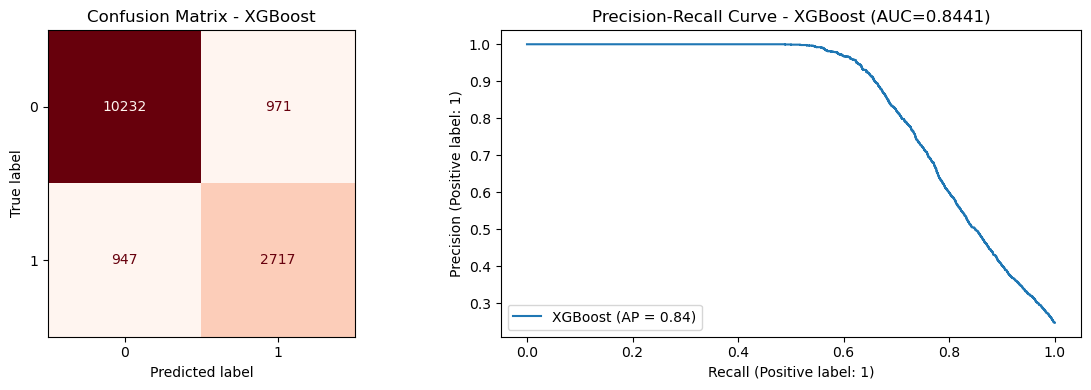

In [89]:
# Predict on the test set
y_pred = grid_search_XGBoost.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get predicted probabilities for the positive class
y_scores = grid_search_XGBoost.predict_proba(X_test)[:, 1]

# Compute average precision (AUC-PR)
auc_pr = average_precision_score(y_test, y_scores)

# Create a figure
fig, axes = plt.subplots(1, # one row
                         2, # two columns
                         figsize=(12, 4)
                        )

# --- Confusion Matrix ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=grid_search_XGBoost.classes_
                             )
disp.plot(cmap="Reds", 
          values_format='d', 
          colorbar=False, #don't show the legend colormap
          ax=axes[0])
axes[0].set_title("Confusion Matrix - XGBoost")

# --- Precision-Recall Curve ---
PrecisionRecallDisplay.from_predictions(y_test, 
                                        y_scores,  
                                        name="XGBoost", 
                                        ax=axes[1]
                                       )
axes[1].set_title(f"Precision-Recall Curve - XGBoost (AUC={auc_pr:.4f})")

plt.tight_layout()
plt.show()

**Notice:** we kept the same balance of the original dataset based on target values for our test set, thanks to the parameter: **`stratify=y`** during the split of the dataset [section 4.](#TrainingTheModels--4). Thus, the preportion of: $ \frac{\text{negatives}}{\text{positives}}=3.05 $, is kept on both training and testing sets.

In [90]:
# Predict on test set
y_pred = grid_search_XGBoost.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
# Precision (by default, for positive class in binary classification)
prec = precision_score(y_test, y_pred)
# Recall
rec = recall_score(y_test, y_pred)
# F1-score
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.8710
Precision: 0.7367
Recall: 0.7415
F1-score: 0.7391


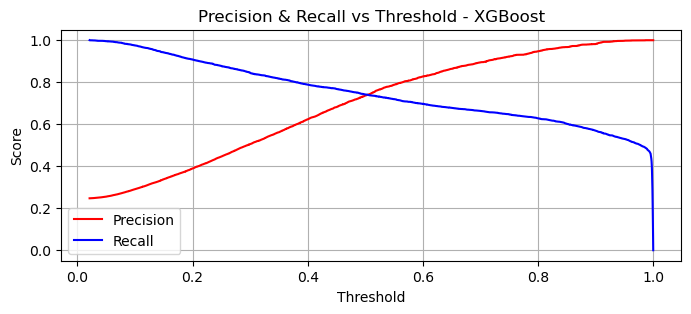

In [91]:
# Get predicted probabilities for the positive class
y_scores = grid_search_XGBoost.predict_proba(X_test)[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Precision and Recall vs Threshold
plt.figure(figsize=(8, 3))
plt.plot(thresholds, precision[:-1], label='Precision', color='red')
plt.plot(thresholds, recall[:-1], label='Recall', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold - XGBoost')
plt.legend()
plt.grid(True)
plt.show()


In [123]:
y_scores = grid_search_XGBoost.predict_proba(X_test)[:, 1]
threshold = 0.4  # lower than 0.5, where it is centered
y_pred_adjusted = (y_scores >= threshold).astype(int)

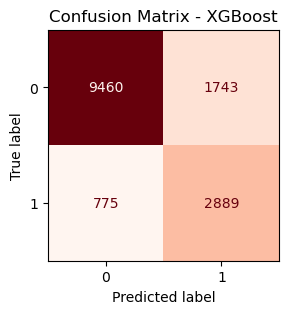

In [124]:
# Compute confusion matrix
cm = confusion_matrix(y_test,
                      y_pred_adjusted
                     )

# Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=grid_search_XGBoost.classes_
                             )
plt.figure(figsize=(3, 3)) #create a specific figure object in order to better manipulate the dimensions

disp.plot(cmap="Reds", 
          values_format='d', #show numbers as integers
          colorbar = False, #colorbar as legend disactivated
          ax=plt.gca() #plot inn the figure created
         )

plt.title("Confusion Matrix - XGBoost")
plt.show()

In [94]:
# Accuracy
acc = accuracy_score(y_test, y_pred_adjusted)
# Precision (by default, for positive class in binary classification)
prec = precision_score(y_test, y_pred_adjusted)
# Recall
rec = recall_score(y_test, y_pred_adjusted)
# F1-score
f1 = f1_score(y_test, y_pred_adjusted)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8306
Precision: 0.6237
Recall: 0.7885
F1-score: 0.6965


The following code block performs *serialization*, it is a very helpful practice that allows to save a model once has been trained, so it saves the training time every time you open the notebook by simply opening directly the saved model.\
There are many libraries that apply serialization and probably one of the best-known is **`pickle`**, even though it is not able to save **`lambda`** functions when present.\
Since this practice can also save the full pipeline, and in our case there are **`lambda`** functions, we ended up using **`cloudpickle`**, that also saves the anonymous functions.\
The storing format is binary.

In [46]:
# --- Saving ---
if recovered is False: #if the model currently used has not been recovered from serialization:
    with open("XGBoost_loan.pkl", mode="wb") as f: #wb stands for Writing Binary
        cloudpickle.dump(grid_search_XGBoost, f)

# --- Loading ---
"""
with open("XGBoost_loan.pkl", mode="rb") as f: #rb stands for reading binary
    XGBoost_recovered = cloudpickle.load(f)
"""

'\nwith open("XGBoost_loan.pkl", mode="rb") as f: #rb stands for reading binary\n    XGBoost_recovered = cloudpickle.load(f)\n'

### 4.2. Adaptive Boosting <a name="AdaBoost--4-2"></a>

In [47]:
"""
Notice, if you do not have enough time, you can skip directly to the following cell, if you already have the proper pkl
object in your folder, since it will open the already trained model.
"""

#Setting AdaBoost classifier (with Decision Tree as base estimator)
ada_model = AdaBoostClassifier(
                                base_estimator=DecisionTreeClassifier(class_weight="balanced", #it balances the dataset
                                                                     ),
                                random_state=42
                            )

#adding to the pipeline the algorithm
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ada_model)
])

# Parameter grid for GridSearch
param_grid = {
    'classifier__base_estimator__max_depth': [2, 3, 4],       #Maximum depth of decision trees
    'classifier__n_estimators': [50, 100, 200],            #Number of boosting stages(how many weak learners to add)
    'classifier__learning_rate': [0.01, 0.1, 0.5, 1.0],    #Shrinkage (learning) rate
    'classifier__algorithm': [#'SAMME', # Boosting algorithms, for our case SAMME.R performs better 
                              'SAMME.R']          
}

# Grid search setup
grid_search_AdaBoost = GridSearchCV(
                            full_pipeline,
                            param_grid,
                            cv=strat_kfold,
                            n_jobs=-1,
                            verbose=2,
                            scoring='recall',
                        )

start_time = time.time() #for counting the time
# Fit GridSearchCV on training data
grid_search_AdaBoost.fit(X_train, 
                y_train
               )
end_time = time.time() #end time of execution
elapsed_time = convert_time(end_time - start_time)
print(f"AdaBoost training + grid search took {elapsed_time}")

# Best params and score
print("Best parameters found:", grid_search_AdaBoost.best_params_)
print("Best cross-validation Recall:", grid_search_AdaBoost.best_score_)

# Evaluate on the test set
test_score = grid_search_AdaBoost.score(X_test, y_test)
print(f"Test set Recall: {test_score:.4f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
AdaBoost training + grid search took 2:31:44
Best parameters found: {'classifier__algorithm': 'SAMME.R', 'classifier__base_estimator__max_depth': 4, 'classifier__learning_rate': 0.1, 'classifier__n_estimators': 200}
Best cross-validation F1-score: 0.7324995639921574
Test set F1-score: 0.7427


In [48]:
#try to see whether the above cell has been run
try: 
    grid_search_AdaBoost
    recovered = False #boolean variable to understand wheter the model has been recovered from serialization or not
    
#otherwise open the serialized model
except:
    with open("AdaBoost_loan.pkl", mode="rb") as f: #rb stands for reading binary
        grid_search_AdaBoost = cloudpickle.load(f)
    recovered = True

In [49]:
pd.DataFrame(grid_search_AdaBoost.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       62.120510      2.206168         1.771080        0.086493   
1      121.915189      2.932119         2.971895        0.047881   
2      234.052945      0.873846         5.440461        0.114611   
3       60.489206      0.194216         1.687679        0.054419   
4      122.506018      2.485021         2.903967        0.041566   
5      233.140962      0.890725         5.340461        0.031613   
6       60.463351      0.265294         1.683442        0.011847   
7      119.991861      2.859640         2.913661        0.051234   
8      235.103316      2.451228         5.248966        0.119677   
9       60.203687      0.157608         1.700604        0.039639   
10     118.208224      1.211308         2.852574        0.041210   
11     239.018456      3.958763         5.233646        0.056889   
12      82.661751      0.209638         1.658854        0.013137   
13     162.407424      2.134627         2.851916        0.012767   
14     325.812421      3.387428         5.251027        0.097480   
15      82.067509      0.295206         1.658273        0.030257   
16     164.287328      1.207196         2.839998        0.036717   
17     323.503259      2.444104         5.363240        0.220310   
18      83.684390      1.862075         1.640940        0.014992   
19     164.574914      2.280620         2.893923        0.081210   
20     336.850410     20.426975         5.465938        0.304663   
21      96.024750      4.437510         1.978555        0.263045   
22     187.442852     14.260074         3.497649        0.717103   
23     329.877241      5.452792         5.235554        0.027391   
24     104.503095      0.365771         1.644897        0.010134   
25     206.460638      2.181519         3.209433        0.757308   
26     408.201184      2.584169         5.207666        0.040051   
27     106.273024      2.518095         1.681098        0.046558   
28     205.590372      0.571843         2.841196        0.035706   
29     412.961495      1.351899         5.244315        0.015023   
30     106.047442      1.134497         1.668929        0.050260   
31     210.917595      0.901920         2.846866        0.021549   
32     414.376339      2.191073         5.235024        0.014371   
33     107.724003      2.174911         1.639389        0.007042   
34     206.917799      0.305905         2.867005        0.048220   
35     382.309717     55.742173         4.526265        1.030460   

   param_classifier__algorithm param_classifier__base_estimator__max_depth  \
0                      SAMME.R                                           2   
1                      SAMME.R                                           2   
2                      SAMME.R                                           2   
3                      SAMME.R                                           2   
4                      SAMME.R                                           2   
5                      SAMME.R                                           2   
6                      SAMME.R                                           2   
7                      SAMME.R                                           2   
8                      SAMME.R                                           2   
9                      SAMME.R                                           2   
10                     SAMME.R                                           2   
11                     SAMME.R                                           2   
12                     SAMME.R                                           3   
13                     SAMME.R                                           3   
14                     SAMME.R                                           3   
15                     SAMME.R                                           3   
16                     SAMME.R                                           3   
17                     SAMME.R                                           3   
18   

In [50]:
#we encapsulate just the best model
AdaBoost_whole_model = grid_search_AdaBoost.best_estimator_ #here we save the whole best model full pipeline (prepocessor + classifier)
AdaBoost_classifier = AdaBoost_whole_model.named_steps['classifier'] #here we save just the best classifier

In [51]:
#recover just the preprocessor from the whole model
preprocessor = AdaBoost_whole_model.named_steps['preprocessor']
feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    #if the transformer is a drop operator
    if transformer == 'drop':
        continue
    #if the transformer is actually a pipeline object, so that has inside other transformers
    if isinstance(transformer, Pipeline):
        #get the last step of the pipeline, because the last step is the one that finally transforms the data and generates new names
        last_step = transformer.steps[-1][1]
        if hasattr(last_step, 'get_feature_names_out'):
            names = last_step.get_feature_names_out(cols)
        else:
            names = cols
    #if the transformer is directly a transformer
    else:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
    
    feature_names.extend(names)

feat_imp = pd.DataFrame({
                        'feature': feature_names,
                        'importance': AdaBoost_classifier.feature_importances_
                        }).sort_values(
                                        by="importance", 
                                        ascending=False
                                        )

print(feat_imp)

                               feature  importance
46                                 LTV    0.163594
44                              income    0.131618
47                               dtir1    0.102922
41                         loan_amount    0.083200
43                      property_value    0.058051
45                        Credit_Score    0.038486
29                     loan_purpose_p3    0.030820
24                     loan_type_type1    0.029853
26                     loan_type_type3    0.029413
27                     loan_purpose_p1    0.028073
48                                 age    0.024692
31                   occupancy_type_ir    0.019251
30                     loan_purpose_p4    0.017919
42                                term    0.015996
8            Neg_ammortization_neg_amm    0.013948
25                     loan_type_type2    0.013775
19   submission_of_application_to_inst    0.012936
13           lump_sum_payment_not_lpsm    0.012614
9            Neg_ammortization_

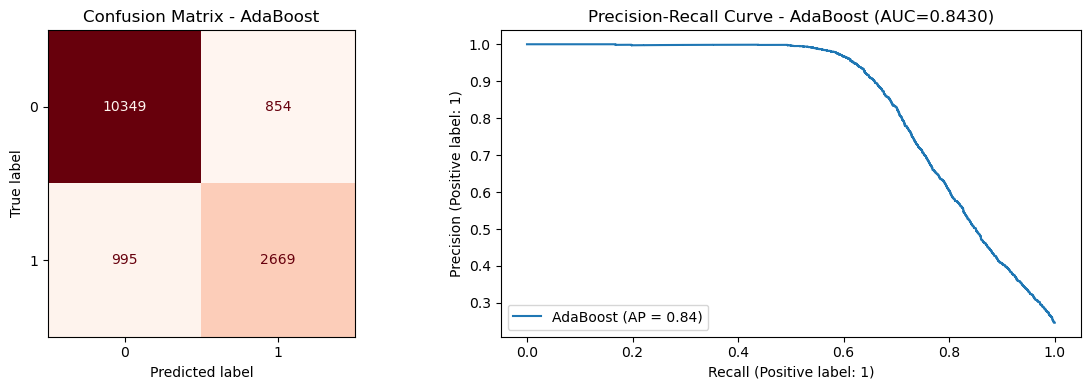

In [52]:
# Predict on the test set
y_pred = grid_search_AdaBoost.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get predicted probabilities for the positive class
y_scores = grid_search_AdaBoost.predict_proba(X_test)[:, 1]

# Compute average precision (AUC-PR)
auc_pr = average_precision_score(y_test, y_scores)

# Create a figure
fig, axes = plt.subplots(1, # one row
                         2, # two columns
                         figsize=(12, 4)
                        )

# --- Confusion Matrix ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=grid_search_AdaBoost.classes_
                             )
disp.plot(cmap="Reds", 
          values_format='d', 
          colorbar=False, #don't show the legend colormap
          ax=axes[0])
axes[0].set_title("Confusion Matrix - AdaBoost")

# --- Precision-Recall Curve ---
PrecisionRecallDisplay.from_predictions(y_test, 
                                        y_scores,  
                                        name="AdaBoost", 
                                        ax=axes[1]
                                       )
axes[1].set_title(f"Precision-Recall Curve - AdaBoost (AUC={auc_pr:.4f})")

plt.tight_layout()
plt.show()

In [53]:
# Predict on test set
y_pred = grid_search_AdaBoost.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
# Precision (by default, for positive class in binary classification)
prec = precision_score(y_test, y_pred)
# Recall
rec = recall_score(y_test, y_pred)
# F1-score
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.8756
Precision: 0.7576
Recall: 0.7284
F1-score: 0.7427


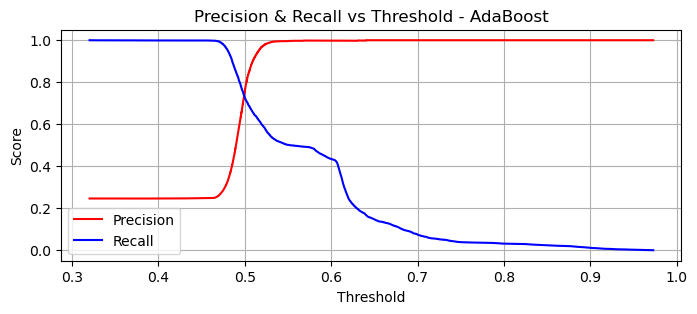

In [54]:
# Get predicted probabilities for the positive class
y_scores = grid_search_AdaBoost.predict_proba(X_test)[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Precision and Recall vs Threshold
plt.figure(figsize=(8, 3))
plt.plot(thresholds, precision[:-1], label='Precision', color='red')
plt.plot(thresholds, recall[:-1], label='Recall', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold - AdaBoost')
plt.legend()
plt.grid(True)
plt.show()


In [78]:
y_scores = grid_search_AdaBoost.predict_proba(X_test)[:, 1]
threshold = 0.495  # lower than 0.5, where it is centered
y_pred_adjusted = (y_scores >= threshold).astype(int)

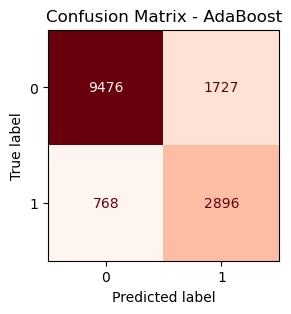

In [79]:
# Compute confusion matrix
cm = confusion_matrix(y_test,
                      y_pred_adjusted
                     )

# Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=grid_search_AdaBoost.classes_
                             )
plt.figure(figsize=(3, 3)) #create a specific figure object in order to better manipulate the dimensions

disp.plot(cmap="Reds", 
          values_format='d', #show numbers as integers
          colorbar = False, #colorbar as legend disactivated
          ax=plt.gca() #plot inn the figure created
         )

plt.title("Confusion Matrix - AdaBoost")
plt.show()

In [80]:
# Accuracy
acc = accuracy_score(y_test, y_pred_adjusted)
# Precision (by default, for positive class in binary classification)
prec = precision_score(y_test, y_pred_adjusted)
# Recall
rec = recall_score(y_test, y_pred_adjusted)
# F1-score
f1 = f1_score(y_test, y_pred_adjusted)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8322
Precision: 0.6264
Recall: 0.7904
F1-score: 0.6989


In [58]:
# --- Saving ---
if recovered is False: #if the model currently used has not been recovered from serialization:
    with open("AdaBoost_loan.pkl", mode="wb") as f: #wb stands for Writing Binary
        cloudpickle.dump(grid_search_AdaBoost, f)

# --- Loading ---
"""
with open("AdaBoost_loan.pkl", mode="rb") as f: #rb stands for reading binary
    AdaBoost_recovered = cloudpickle.load(f)
"""

'\nwith open("AdaBoost_loan.pkl", mode="rb") as f: #rb stands for reading binary\n    AdaBoost_recovered = cloudpickle.load(f)\n'

### 4.3. Gradient Boosting <a name="GradientBoosting--4-3"></a>

In [59]:
"""
Notice, if you do not have enough time, you can skip directly to the following cell, if you already have the proper pkl
object in your folder, since it will open the already trained model.
"""

#setting the GradientBoosting model
gb_model = GradientBoostingClassifier(
                                    random_state=42
                                )

#adding to the pipeline the algorithm
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', gb_model)
])

# Parameter grid for GridSearch
param_grid = {
    'classifier__n_estimators': [200, 250, 400],          #Number of boosting stages(how many weak learners to add)
    'classifier__learning_rate': [0.1, 0.2, 0.3],       #Shrinkage (learning) rate
    'classifier__max_depth': [3, 5],                  #Maximum depth of decision trees
    'classifier__subsample': [0.8, 1.0],                 #fraction of samples used for fitting each tree (classic gradient boosting Vs Stochastic)
    'classifier__min_samples_split': [5, 10]              #minimum samples required to split a node
}

# Grid search setup
grid_search_GradientBoost = GridSearchCV(
                            full_pipeline,
                            param_grid,
                            cv=strat_kfold,
                            n_jobs=-1,
                            verbose=2,
                            scoring='recall',
                        )

start_time = time.time() #for counting the time
# Fit GridSearchCV on training data
grid_search_GradientBoost.fit(X_train, 
                                y_train
                               )
end_time = time.time() #end time of execution
elapsed_time = convert_time(end_time - start_time)
print(f"GradientBoost training + grid search took {elapsed_time}")

# Best params and score
print("Best parameters found:", grid_search_GradientBoost.best_params_)
print("Best cross-validation Recall:", grid_search_GradientBoost.best_score_)

# Optional: Evaluate on the test set
test_score = grid_search_GradientBoost.score(X_test, y_test)
print(f"Test set Recall: {test_score:.4f}")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
GradientBoost training + grid search took 11:53:06
Best parameters found: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_samples_split': 10, 'classifier__n_estimators': 400, 'classifier__subsample': 1.0}
Best cross-validation F1-score: 0.7463797980725788
Test set F1-score: 0.7626


In [60]:
#try to see whether the above cell has been run
try: 
    grid_search_GradientBoost
    recovered = False #boolean variable to understand wheter the model has been recovered from serialization or not
    
#otherwise open the serialized model
except:
    with open("GradientBoost_loan.pkl", mode="rb") as f: #rb stands for reading binary
        grid_search_GradientBoost = cloudpickle.load(f)
    recovered = True

In [61]:
pd.DataFrame(grid_search_GradientBoost.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0      231.044587      2.242893         0.885861        0.040543   
1      279.309331      8.187863         0.865561        0.057509   
2      294.869365      5.948133         0.971381        0.032416   
3      356.088952      2.268591         0.956296        0.009579   
4      465.187428      1.760421         1.251367        0.010026   
..            ...           ...              ...             ...   
67     427.109481      1.972203         0.908923        0.015009   
68     433.709136      2.448850         1.023926        0.011757   
69     533.652603      2.279444         1.023622        0.006619   
70     692.917323      2.418478         1.372511        0.027700   
71     754.299920    133.903629         1.066091        0.291143   

   param_classifier__learning_rate param_classifier__max_depth  \
0                              0.1                           3   
1                              0.1                           3   
2                              0.1                           3   
3                              0.1                           3   
4                              0.1                           3   
..                             ...                         ...   
67                             0.3                           5   
68                             0.3                           5   
69                             0.3                           5   
70                             0.3                           5   
71                             0.3                           5   

   param_classifier__min_samples_split param_classifier__n_estimators  \
0                                    5                            200   
1                                    5                            200   
2                                    5                            250   
3                                    5                            250   
4                                    5                            400   
..                                 ...                            ...   
67                                  10                            200   
68                                  10                            250   
69                                  10                            250   
70                                  10                            400   
71                                  10                            400   

   param_classifier__subsample  \
0                          0.8   
1                          1.0   
2                          0.8   
3                          1.0   
4                          0.8   
..                         ...   
67                         1.0   
68                         0.8   
69                         1.0   
70                         0.8   
71                         1.0   

                                               params  split0_test_score  \
0   {'classifier__learning_rate': 0.1, 'classifier...           0.725642   
1   {'classifier__learning_rate': 0.1, 'classifier...           0.725556   
2   {'classifier__learning_rate': 0.1, 'classifier...           0.730494   
3   {'classifier__learning_rate': 0.1, 'classifier...           0.729483   
4   {'classifier__learning_rate': 0.1, 'classifier...           0.737524   
..                                                ...                ...   
67  {'classifier__learning_rate': 0.3, 'classifier...           0.745325   
68  {'classifier__learning_rate': 0.3, 'classifier...           0.743452   
69  {'classifier__learning_rate': 0.3, 'classifier...           0.741254   
70  {'classifier__learning_rate': 0.3, 'classifier...           0.741800   
71  {'classifier__learning_rate': 0.3, 'classifier...           0.742188   

    split1_test_score  split2_test_score  split3_test_score  \
0            0.725439           0.726333           0.723852   
1            0.726213           0.722057           0.721693   
2     

In [62]:
#we encapsulate just the best model
GradientBoost_whole_model = grid_search_GradientBoost.best_estimator_ #here we save the whole best model full pipeline (prepocessor + classifier)
GradientBoost_classifier = GradientBoost_whole_model.named_steps['classifier'] #here we save just the best classifier

In [63]:
#recover just the preprocessor from the whole model
preprocessor = GradientBoost_whole_model.named_steps['preprocessor']
feature_names = []

for name, transformer, cols in preprocessor.transformers_:
    #if the transformer is a drop operator
    if transformer == 'drop':
        continue
    #if the transformer is actually a pipeline object, so that has inside other transformers
    if isinstance(transformer, Pipeline):
        #get the last step of the pipeline, because the last step is the one that finally transforms the data and generates new names
        last_step = transformer.steps[-1][1]
        if hasattr(last_step, 'get_feature_names_out'):
            names = last_step.get_feature_names_out(cols)
        else:
            names = cols
    #if the transformer is directly a transformer
    else:
        if hasattr(transformer, 'get_feature_names_out'):
            names = transformer.get_feature_names_out(cols)
        else:
            names = cols
    
    feature_names.extend(names)

feat_imp = pd.DataFrame({
                        'feature': feature_names,
                        'importance': AdaBoost_classifier.feature_importances_
                        }).sort_values(
                                        by="importance", 
                                        ascending=False
                                        )

print(feat_imp)

                               feature  importance
46                                 LTV    0.163594
44                              income    0.131618
47                               dtir1    0.102922
41                         loan_amount    0.083200
43                      property_value    0.058051
45                        Credit_Score    0.038486
29                     loan_purpose_p3    0.030820
24                     loan_type_type1    0.029853
26                     loan_type_type3    0.029413
27                     loan_purpose_p1    0.028073
48                                 age    0.024692
31                   occupancy_type_ir    0.019251
30                     loan_purpose_p4    0.017919
42                                term    0.015996
8            Neg_ammortization_neg_amm    0.013948
25                     loan_type_type2    0.013775
19   submission_of_application_to_inst    0.012936
13           lump_sum_payment_not_lpsm    0.012614
9            Neg_ammortization_

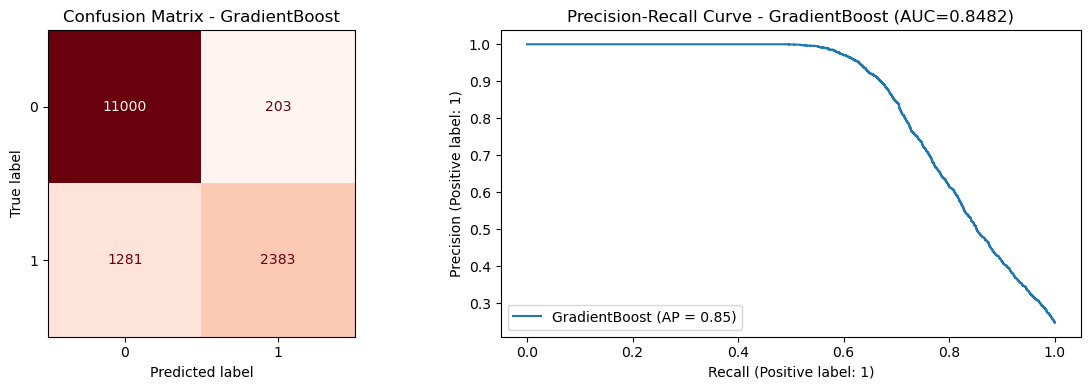

In [64]:
# Predict on the test set
y_pred = grid_search_GradientBoost.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get predicted probabilities for the positive class
y_scores = grid_search_GradientBoost.predict_proba(X_test)[:, 1]

# Compute average precision (AUC-PR)
auc_pr = average_precision_score(y_test, y_scores)

# Create a figure
fig, axes = plt.subplots(1, # one row
                         2, # two columns
                         figsize=(12, 4)
                        )

# --- Confusion Matrix ---
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=grid_search_GradientBoost.classes_
                             )
disp.plot(cmap="Reds", 
          values_format='d', 
          colorbar=False, #don't show the legend colormap
          ax=axes[0])
axes[0].set_title("Confusion Matrix - GradientBoost")

# --- Precision-Recall Curve ---
PrecisionRecallDisplay.from_predictions(y_test, 
                                        y_scores,  
                                        name="GradientBoost", 
                                        ax=axes[1]
                                       )
axes[1].set_title(f"Precision-Recall Curve - GradientBoost (AUC={auc_pr:.4f})")

plt.tight_layout()
plt.show()

In [65]:
# Predict on test set
y_pred = grid_search_GradientBoost.predict(X_test)

# Accuracy
acc = accuracy_score(y_test, y_pred)
# Precision (by default, for positive class in binary classification)
prec = precision_score(y_test, y_pred)
# Recall
rec = recall_score(y_test, y_pred)
# F1-score
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")


Accuracy: 0.9002
Precision: 0.9215
Recall: 0.6504
F1-score: 0.7626


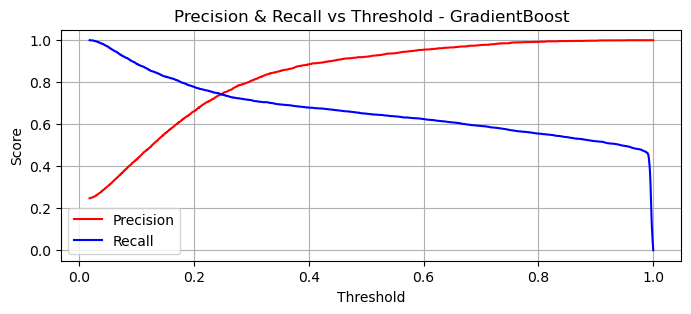

In [66]:
# Get predicted probabilities for the positive class
y_scores = grid_search_GradientBoost.predict_proba(X_test)[:, 1]

# Compute precision, recall, thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot Precision and Recall vs Threshold
plt.figure(figsize=(8, 3))
plt.plot(thresholds, precision[:-1], label='Precision', color='red')
plt.plot(thresholds, recall[:-1], label='Recall', color='blue')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision & Recall vs Threshold - GradientBoost')
plt.legend()
plt.grid(True)
plt.show()


In [83]:
y_scores = grid_search_GradientBoost.predict_proba(X_test)[:, 1]
threshold = 0.2  # lower than 0.5, where it is centered
y_pred_adjusted = (y_scores >= threshold).astype(int)

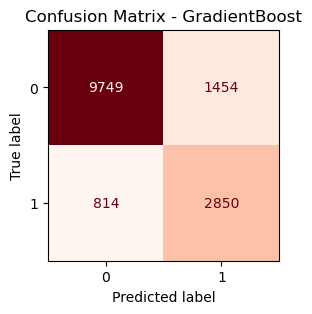

In [84]:
# Compute confusion matrix
cm = confusion_matrix(y_test,
                      y_pred_adjusted
                     )

# Display confusion matrix as a heatmap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                              display_labels=grid_search_GradientBoost.classes_
                             )
plt.figure(figsize=(3, 3)) #create a specific figure object in order to better manipulate the dimensions

disp.plot(cmap="Reds", 
          values_format='d', #show numbers as integers
          colorbar = False, #colorbar as legend disactivated
          ax=plt.gca() #plot inn the figure created
         )

plt.title("Confusion Matrix - GradientBoost")
plt.show()

In [69]:
# Accuracy
acc = accuracy_score(y_test, y_pred_adjusted)
# Precision (by default, for positive class in binary classification)
prec = precision_score(y_test, y_pred_adjusted)
# Recall
rec = recall_score(y_test, y_pred_adjusted)
# F1-score
f1 = f1_score(y_test, y_pred_adjusted)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {rec:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.8474
Precision: 0.6622
Recall: 0.7778
F1-score: 0.7154


In [70]:
# --- Saving ---
if recovered is False: #if the model currently used has not been recovered from serialization:
    with open("GradientBoost_loan.pkl", mode="wb") as f: #wb stands for Writing Binary
        cloudpickle.dump(grid_search_GradientBoost, f)

# --- Loading ---
"""
with open("GradientBoost_loan.pkl", mode="rb") as f: #rb stands for reading binary
    GradientBoost_recovered = cloudpickle.load(f)
"""

'\nwith open("GradientBoost_loan.pkl", mode="rb") as f: #rb stands for reading binary\n    GradientBoost_recovered = cloudpickle.load(f)\n'

## 5. Comparisons <a name="Comparisons--5"></a>

Now that all three models have been run we can make comparisons and draw conclusions.

Since in our dataset the positive class is rare, as a rule of thumb we should prefer the Precision-Recall curves for comparisons, hence we will combine them with the best scores found after tweaking the precision-recall threshold, in order to choose the best model.

<div style="display: flex; justify-content: center; text-align: center;">

  <div>
      XGBoost
      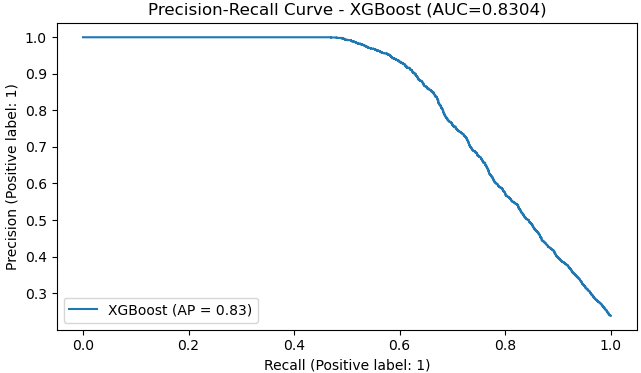<br>
      Accuracy: 0.8300 <br>
      Precision: 0.6105 <br>
      Recall: 0.7780 <br>
      F1-score: 0.6842
  </div>

  <div>
      AdaBoost
      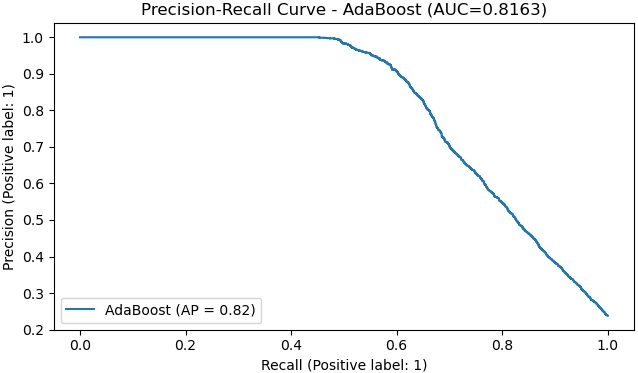<br>
      Accuracy: 0.8247 <br>
      Precision: 0.6020 <br>
      Recall: 0.7652 <br>
      F1-score: 0.6738
  </div>

  <div>
      GradientBoost
      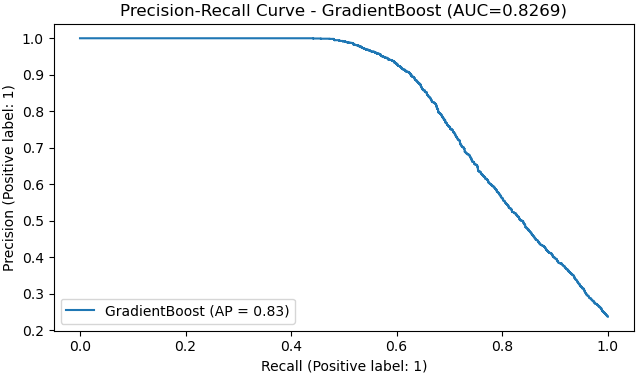<br>
      Accuracy: 0.8444 <br>
      Precision: 0.6470 <br>
      Recall: 0.7533 <br>
      F1-score: 0.6961
  </div>

</div>

<span style="font-size:80%"> See [Appendix 7.B.](#Appendix--7-B) to understand how these images have been generated </span>

All three models are quite good, and have similar scores, even though AdaBoost is clearly the one with the lowest scores.\
On the other hand XGBoost and GradientBoost have different scores each one with its own pros and cons, if we take into account the overall F1-score that is basically the harmonic mean between precision and recall:

$$ \text{F1-score} = 2 \cdot \frac{\text{precision} \cdot \text{recall}}{\text{precision} \ + \ \text{recall}} $$

we would choose GradientBoost, since this metric is comprehensive of both Precision and Recall.\
On the other hand if we take into account the general principle of this project, we want to prioritize recall over precision and even further we take a look at the training time:

|   XGBoost                 |   AdaBoost                 |   GradientBoost                 |
|   :-------------------:   |   :--------------------:   |   :-------------------------:   |
|         00:03:48          |          01:36:11          |            03:15:27              |

XGBoost is the one that performs better.\
This is due to some intrinsic characteristics of the implementation of the algorithm itself. XGBoost is built upon the core Gradient Boosting framework, but it has some key features such as smarter penalizations and regularization, adopts Newton Boosting,  furthermore XGBoost can build parts of the model in parallel. This not only speeds up the training process but also makes it scalable, allowing it to handle very large datasets by distributing the workload across multiple machines or processing units.

## 6. Conclusion and Possible Expansions <a name="ConclusionsAndPossibleExpansions--6"></a>

A simple and very effective strategy that we can implement in order to enhance quickly our models can be achieved by comparing the best parameters found for each model with the ranges that we have set in the **`param_grid`** dictionaries.\
By doing so, we can tweak the ranges accordingly and re-run the models many times until we reach the optimal solutions with the proper ranges.\
With a similar approach we can even expand the *hyperparameters* to tweak, since there exist many more, of course this will lead to slow down the process. A possible way to cope with this latter issue is by using **`RandomizedSearchCV`**, it evaluates a given number of random combinations by selecting a random value for each hyperparameter at every iteration.

This project can be further improved under some aspects that can be seen as a good starting point for future directions.\
One of the first improvement that can come up in mind straight away after analyzing section [4](#TrainingTheModels--4) is the further feature selection, since all three algorithms under the hood of features importance show that: **`open_credit_opc`**, **`open_credit_nopc`** and **`construction_type_sb`** have no importance in reducing impurity.\
Plotting the **learning curves** and eventually implementing some strategies such as **early stopping** can be very beneficial especially for Adaptive Boosting and Gradient Boosting, since they take long time for training.\
Since the dataset results a bit unbalanced towards the negative samples, we could implement **SMOTE** *(Synthetic Minority Over-sampling Technique)* techniques in order to generate synthetic samples from the minority class, so to compensate it.\
Furthermore we can try to apply dimensionality reduction and/or different models, maybe even approaching the field of Artificial Neural Netwroks, starting with the base model of the Multilayer Perceptron.

The main purpose of this notebook has originally started as a Kaggle challenge, it can be actually seen a good starting point for many other interesting applications, not necessarily related to the credit industry.\
For example with the same binary classifier concept we can implement fraud dectors, spam email dector, malicious cyber attacks identifications and so on...

## 7. Appendix <a name="Appendix--7"></a>

This section contains some tips and interesting tricks that I have used during the execution of this Notebook.

### 7.A. Python stay-awake module <a name="Appendix--7-A"></a>

At the end of section [5.](#Comparisons--5) we higlighted the training time for the three models. If we sum all training times we quickly understand that in total, running this notebook from scratch requires approximately five hours.\
If we do not want to change the settings of our computer in order to prevent sleep mode, we can use a python script that runs in a different thread as a background daemon, since it requires very few CPU.\
Online there are many modules from which we can take advantage of.

For example this one [here](https://pypi.org/project/stay-awake/) is very easy and straighforward to implement, even though if you run it on Windows 10 or newer versions you need to adjust it a bit, because you need to automatic mouse moving does not prevent sleep mode anymore [see](https://github.com/singhsidhukuldeep/stay-awake/issues/201).\
For example once you have found out the location of the script in your computer with: **`pip show stay-awake`** you can change the **`__init__.py`** inside the `stay-wake` folder script so that instead of moving the mouse it activates/deactives the ScrollLock button.

Once the script is ready, it is very easy to use it, just open a Shell prompt ad type: **`python -m stay-awake`**\
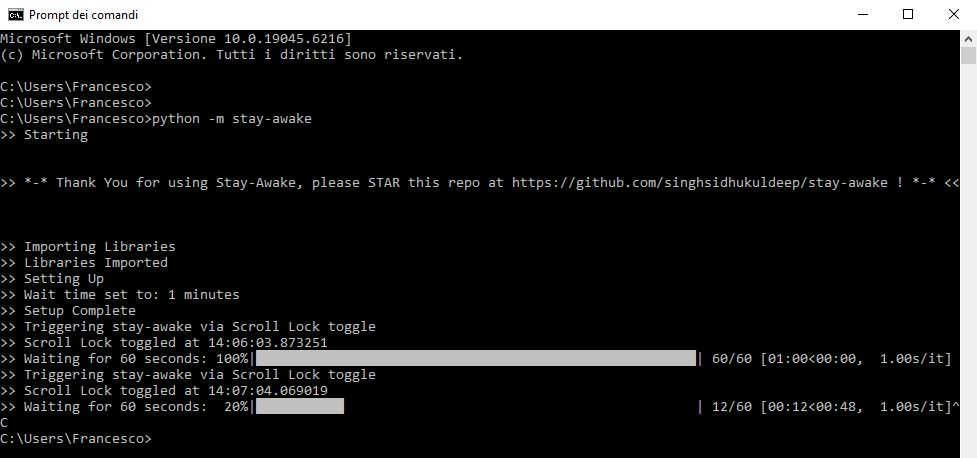

<span style="font-size:80%"> See [Appendix 7.B.](#Appendix--7-B) to understand how this image has been generated </span>

### 7.B. Python  image converter base64 (PDF exporting) <a name="Appendix--7-B"></a>

If we want to convert a file Jupyter Notebook with images into PDF format, all the media attachments will be lost, this is a well-known bug of ipynb files.\
In order to overcome this issue there a few tricks, the one I have implemented is based on the Python library **`base64`**. Basically it converts images into ASCII characters, by opening the attachments in binary mode and then encoding it in series of printable characters limited to a set of 64 unique characters. More specifically, the source binary data is taken 6 bits at a time, then this group of 6 bits is mapped to one of 64 unique characters.

Base64 encoding causes an overhead of 33–37% relative to the size of the original binary data (33% by the encoding itself; up to 4% more by the inserted line breaks).

For further explanations see: [GitHub issue](https://github.com/jupyter/nbconvert/issues/1079), [Base64](https://en.wikipedia.org/wiki/Base64)

The following block of codes are the ones that generated the encoding and stored directly the content into **`HTML`** tags for the images we saw through this notebook earlier.\
Of course, once the attachment has been encoded, we can remove it from the directory.

For the sake of brevity we do not show the output of the blocks.

Each block is led by the **`Markdown`** referenced cell, that we would have written in case we had not had any issues.

In [ ]:
<img src="loan.JPG" style="width:75%;">

In [ ]:
import base64 #library for base64 encoding

file = "loan.JPG"

with open(file, "rb") as f:
    data = f.read()

encoded = base64.b64encode(data).decode("utf-8")

# Genera il tag HTML con base64
html_code = f'<img src="data:image/jpeg;base64,{encoded}" style="width:75%;">'

# print(html_code)

In [ ]:
<div style="display: flex; 
            justify-content: center; 
            text-align: center;">
    
  <div>
      XGBoost
    <img src="PR-curve XGBoost.png" style="padding:1%"><br>
    Accuracy: 0.8300 <br>
    Precision: 0.6105 <br>
    Recall: 0.7780 <br>
    F1-score: 0.6842
  </div>
  
  <div>
      AdaBoost
    <img src="PR-curve AdaBoost.png" style="padding:1%"><br>
    Accuracy: 0.8247 <br>
    Precision: 0.6020 <br>
    Recall: 0.7652 <br>
    F1-score: 0.6738
  </div>
  
  <div>
      GradientBoost
    <img src="PR-curve GradientBoost.png" style="padding:1%"><br>
    Accuracy: 0.8444 <br>
    Precision: 0.6470 <br>
    Recall: 0.7533 <br>
    F1-score: 0.6961
  </div>
    
</div>

In [ ]:
files = ["PR-curve XGBoost.png", 
         "PR-curve AdaBoost.png", 
         "PR-curve GradientBoost.png",
        ]
labels = ["XGBoost",
          "AdaBoost", 
          "GradientBoost",
         ]
accuracy = [0.8300, 
            0.8247, 
            0.8444,
           ]
precision = [0.6105, 
             0.6020, 
             0.6470,
            ]
recall = [0.7780, 
          0.7652, 
          0.7533,
         ]
f1 = [0.6842, 
      0.6738,
      0.6961,
     ]

html = '<div style="display: flex; justify-content: center; text-align: center;">\n\n'

for i in range(len(files)):
    with open(files[i], "rb") as f:
        data = f.read()
    encoded = base64.b64encode(data).decode("utf-8")
    
    html += f'''  <div>
      {labels[i]}
      <img src="data:image/png;base64,{encoded}" style="padding:1%"><br>
      Accuracy: {accuracy[i]:.4f} <br>
      Precision: {precision[i]:.4f} <br>
      Recall: {recall[i]:.4f} <br>
      F1-score: {f1[i]:.4f}
  </div>\n\n'''

html += '</div>'

# print(html)

In [ ]:
<img src="stay-awake.JPG" style="width:75%;">

In [ ]:
file = "stay-awake.JPG"

with open(file, "rb") as f:
    data = f.read()

encoded = base64.b64encode(data).decode("utf-8")

html_code = f'<img src="data:image/jpeg;base64,{encoded}" style="width:75%;">'

# print(html_code)

# TODO!

- PAY ATTENTION SINCE I'VE CHANGED ALL MODELS THE OUTPUT DATA ARE DIFFERENT!!! => change: images, data, conclusions, thresholds... accordingly